# 极射赤平投影描述符的提取总体流程（Doyle数据集）

## 1. 安装依赖

In [12]:
import glob,os
from Jishe import Jishe,getGridDesc
from SPMS import SPMS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [13]:
# 使用划分网格的方法将平面上离散的点转换成规则的矩阵
def grid_heat_map(x, y, num_bins, colors, x_min=-8, x_max=8, y_min=-8, y_max=8):
    # 使用自定义的坐标范围创建网格
    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # 使用 numpy.histogram2d 函数统计每个格子中的散点数量和颜色值总和
    hist_count, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    hist_colors, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=colors)

    # 计算每个格子的平均颜色值
    with np.errstate(divide='ignore', invalid='ignore'):
        average_colors = np.divide(hist_colors, hist_count)
    # average_colors = np.nan_to_num(average_colors, nan=0.0)  # 处理可能出现的除零情况
    average_colors = np.nan_to_num(average_colors)

    # print(average_colors.T)
    return average_colors.T
#     return average_colors

def getGridDesc(projected_points, x_min=-8, x_max=8, y_min=-8, y_max=8, num_bins=50, normalize=True):
    # 分离正值和负值的数据
    x_coords = projected_points[:, 0]
    y_coords = projected_points[:, 1]
    colors = projected_points[:, 2]
    positive_data = projected_points[colors > 0]
    negative_data = projected_points[colors < 0]
    abs_colors = np.abs(colors)
    if normalize:
        normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
    else:
        normalized_abs_colors = abs_colors

    # 定义格子的行数和列数
#     num_bins = 50
    #     grid_heat_map(x_coords, y_coords, num_bins, heat_colors, 'Grid Heatmap')
    pos_data = grid_heat_map(positive_data[:, 0], positive_data[:, 1], num_bins, normalized_abs_colors[colors > 0], x_min, x_max, y_min, y_max)
    neg_data = grid_heat_map(negative_data[:, 0], negative_data[:, 1], num_bins, normalized_abs_colors[colors < 0], x_min, x_max, y_min, y_max)

#     descriptor = np.concatenate([pos_data, neg_data], axis=1)
    descriptor = np.concatenate([pos_data[::-1], neg_data[::-1]], axis=1)
    
    return descriptor

## 2. 数据集的获取

In [14]:
result_df = pd.read_csv('./Doyle/data1.csv')
lig_smiles = result_df['Ligand'].to_list()
add_smiles = result_df['Additive'].to_list()
base_smiles = result_df['Base'].to_list()
ar_smiles = result_df['Aryl halide'].to_list()
ddG = result_df['Output'].to_list() 

lig_smiles_set = list(set(lig_smiles))
add_smiles_set = list(set(add_smiles))
base_smiles_set = list(set(base_smiles))
ar_smiles_set = list(set(ar_smiles))

In [15]:
add_sdf_files = glob.glob('./Doyle/Replace/ReplaceAdd/*.sdf')
ar_sdf_files = glob.glob('./Doyle/Replace/ReplaceAr_Ha/*.sdf')
base_sdf_files = glob.glob('./Doyle/Replace/ReplaceBase/*.sdf')
lig_sdf_files = glob.glob('./Doyle/Replace/ReplaceLig/*.sdf')

In [16]:
lig_key_atom_num=[16,17,15]
add_key_atom_num=[4,3,5]
base_key_atom_num=[2,6,8]
ar_key_atom_num = [2,1,3]

## 3. 自定义函数

In [17]:
# 获取所有分子极射赤平投影得到的二维点集x方向和y方向的最大范围，用于后续的网格划分
def get_xy_range(projected_points_list):
    # 初始化用于统计所有数据集范围的变量
    all_max_x = -np.inf
    all_min_x = np.inf
    all_max_y = -np.inf
    all_min_y = np.inf

    # 遍历所有数据集，找到最大和最小的 x 和 y 值
    for projected_points in projected_points_list:
        x_coords = projected_points[:, 0]
        y_coords = projected_points[:, 1]

        max_x = np.max(x_coords)
        min_x = np.min(x_coords)
        max_y = np.max(y_coords)
        min_y = np.min(y_coords)

        # 更新所有数据集的范围
        all_max_x = max(all_max_x, max_x)
        all_min_x = min(all_min_x, min_x)
        all_max_y = max(all_max_y, max_y)
        all_min_y = min(all_min_y, min_y)

    return all_min_x, all_max_x, all_min_y, all_max_y

In [18]:
# 计算二维坐标系中原点经过网格划分之后所在的网格，用于划分不同的象限
def get_origin_grid_position(x_min, x_max, y_min, y_max, num_bins):
    
    # 坐标原点
    x_origin = 0
    y_origin = 0
    
    # 使用自定义的坐标范围创建网格
    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # 计算原点在 x 和 y 方向上的相对位置
    x_relative = (x_origin - x_min) / (x_max - x_min)
    y_relative = (y_origin - y_min) / (y_max - y_min)

    # 计算原点所在的行和列
    row = num_bins - int(np.floor(y_relative * num_bins))
    col = int(np.floor(x_relative * num_bins))
    
    return row, col

In [19]:
# 计算第一个网格中心原来所在的坐标位置以及网格之间的距离，用于分子表面的重塑和重要性的分析
def get_xy_step(x_min, x_max, y_min, y_max, num_bins):
    
    x_min_mid = x_min + (x_max - x_min) / (2 * num_bins)
    x_step = (x_max - x_min) / (num_bins)
    
    y_min_mid = y_min + (y_max - y_min) / (2 * num_bins)
    y_step = (y_max - y_min) / (num_bins)
    
    return x_min_mid, x_step, y_min_mid, y_step

In [20]:
# Generate local steric and electronic information
with open('./Doyle/smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()

smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [21]:
%matplotlib inline

## 4. Ligand的描述符提取

In [22]:
lig_sdf_files[0]

'./Doyle/Replace/ReplaceLig/lig_0.sdf'

In [23]:
lig_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('.')[0].split('_')[1]))
all_radius = []
lig_id_name_dict = {}
for index,tmp_sdf_file in enumerate(lig_sdf_files):
    tmp_fn = tmp_sdf_file.split('/')[-1].split('.')[0]
    lig_id_name_dict[tmp_fn] = index
    
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

In [24]:
default_radius

9.0

In [25]:
projected_points_list = np.load('./Doyle/Jishe_81/lig_projected_points.npy')

In [26]:
projected_points_list[0].shape

(3837, 4)

In [27]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-5.231702847222439 5.493427079644933 -6.366523004927572 4.544483128061318


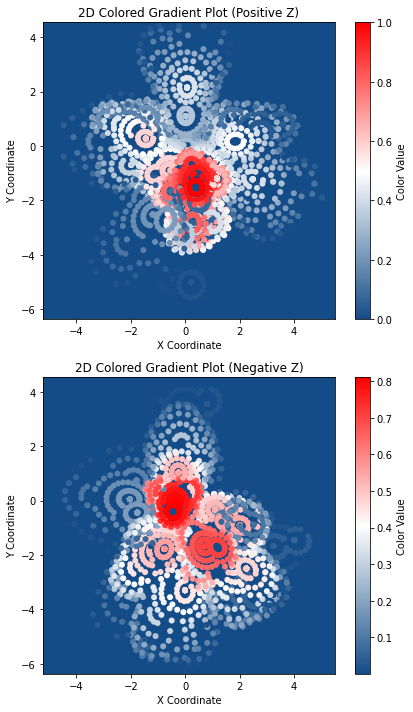

In [28]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
# 为了让y轴方向向下
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

In [29]:
row_lig, col_lig = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [30]:
row_lig, col_lig

(9, 9)

In [31]:
x_min_mid_lig, x_step_lig, y_min_mid_lig, y_step_lig = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [32]:
x_min_mid_lig, x_step_lig, y_min_mid_lig, y_step_lig

(-4.963574599050755, 0.5362564963433686, -6.09374785160285, 0.5455503066494445)

<AxesSubplot:>

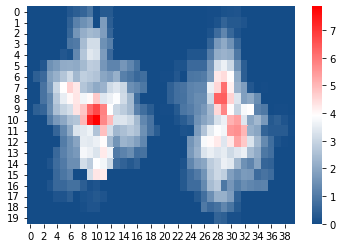

In [33]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

lig_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

sns.heatmap(lig_matric,cbar=True,cmap=custom_cmap)

In [34]:
### Execute this cell will take few seconds or few minutes
lig_spms = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    lig_spms.append(desc)
lig_spms = np.array(lig_spms)

## 5. Base的描述符提取 

In [35]:
base_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('.')[0].split('_')[1]))
all_radius = []
base_id_name_dict = {}
for index,tmp_sdf_file in enumerate(base_sdf_files):
    tmp_fn = tmp_sdf_file.split('/')[-1].split('.')[0]
    base_id_name_dict[tmp_fn] = index
    
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

In [36]:
default_radius

7.0

In [37]:
projected_points_list = np.load('./Doyle/Jishe_81/base_projected_points.npy')

In [38]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-2.9821711638866923 7.566492465335924 -6.078032568392435 3.639039435230395


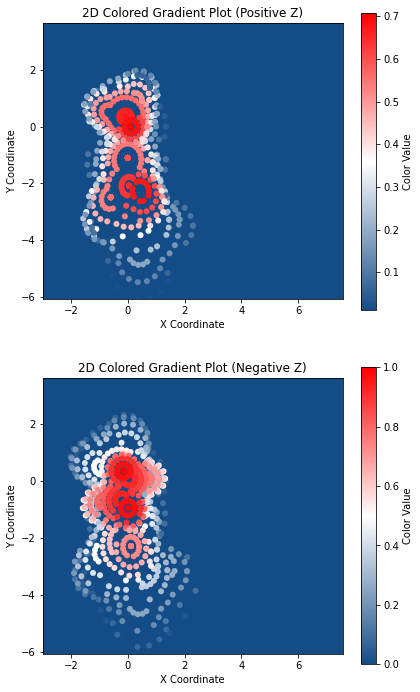

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

<AxesSubplot:>

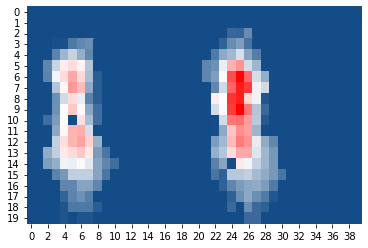

In [40]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# import seanborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]
base_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

sns.heatmap(base_matric,cbar=False,cmap=custom_cmap)

In [41]:
row_base, col_base = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [42]:
x_min_mid_base, x_step_base, y_min_mid_base, y_step_base = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [43]:
### Execute this cell will take few seconds or few minutes
base_spms = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    base_spms.append(desc)
base_spms = np.array(base_spms)

## 7. Additive的描述符提取 

In [44]:
add_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('.')[0].split('_')[1]))
all_radius = []
add_id_name_dict = {}
for index,tmp_sdf_file in enumerate(add_sdf_files):
    tmp_fn = tmp_sdf_file.split('/')[-1].split('.')[0]
    add_id_name_dict[tmp_fn] = index
    
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

/home/liyuan/Pycharm/pythonProject/3DChemical/3D/main/SPMS/Example/SPMS.py:121: RuntimeWarning: invalid value encountered in double_scalars
  X_v[0:3])/(np.sqrt(Xv_xy[0:3].dot(Xv_xy[0:3]))*np.sqrt(X_v[0:3].dot(X_v[0:3]))))


In [45]:
default_radius

nan

In [46]:
projected_points_list = np.load('./Doyle/Jishe_81/add_projected_points.npy')

In [47]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-4.25689414664148 3.96869108956986 -8.368698298240828 2.466672958033113


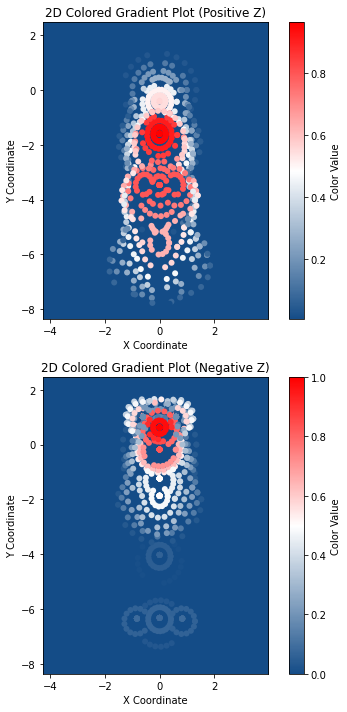

In [48]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

<AxesSubplot:>

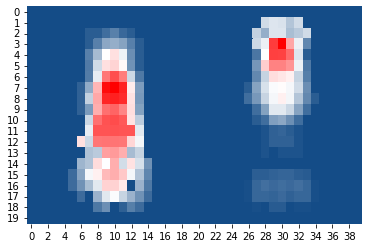

In [49]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# import seanborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

add_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

sns.heatmap(add_matric,cbar=False,cmap=custom_cmap)

In [50]:
row_add, col_add = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [51]:
x_min_mid_add, x_step_add, y_min_mid_add, y_step_add = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [52]:
### Execute this cell will take few seconds or few minutes
add_spms = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    add_spms.append(desc)
add_spms = np.array(add_spms)

## 8. Ar_hadalieve极射赤贫提取

In [53]:
ar_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('.')[0].split('_')[-1]))
all_radius = []
ar_id_name_dict = {}
for index,tmp_sdf_file in enumerate(ar_sdf_files):
    tmp_fn = tmp_sdf_file.split('/')[-1].split('.')[0]
    ar_id_name_dict[tmp_fn] = index
    
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

In [54]:
default_radius

nan

In [55]:
projected_points_list = np.load('./Doyle/Jishe_81/ar_projected_points.npy')

In [56]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-1.88867666586917 1.6999999999999997 -2.4900479771128414 3.358651522478609


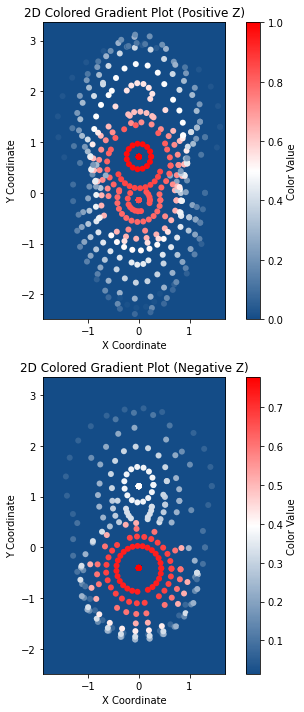

In [57]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

<AxesSubplot:>

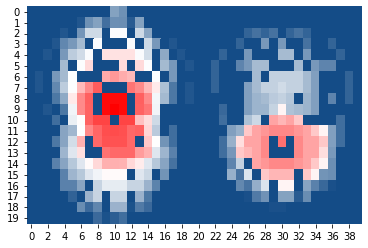

In [58]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# import seanborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[0]
ar_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

sns.heatmap(ar_matric,cbar=False,cmap=custom_cmap)

In [59]:
row_ar, col_ar = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [60]:
x_min_mid_ar, x_step_ar, y_min_mid_ar, y_step_ar = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [61]:
### Execute this cell will take few seconds or few minutes
ar_spms = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    ar_spms.append(desc)
ar_spms = np.array(ar_spms)

## 8. 按照反应顺序依次取出不同底物的描述符

In [62]:
new_lig_desc_dict = {}
for tmp_key in lig_smiles_set:
    id = lig_id_name_dict[smiles_name_dict[tmp_key]]
    new_lig_desc_dict[tmp_key] = lig_spms[id]

new_add_desc_dict = {}
for tmp_key in add_smiles_set:
    id = add_id_name_dict[smiles_name_dict[tmp_key]]
    new_add_desc_dict[tmp_key] = add_spms[id]
    
new_base_desc_dict = {}
for tmp_key in base_smiles_set:
    id = base_id_name_dict[smiles_name_dict[tmp_key]]
    new_base_desc_dict[tmp_key] = base_spms[id]
    
new_ar_desc_dict = {}
for tmp_key in ar_smiles_set:
    id = ar_id_name_dict[smiles_name_dict[tmp_key]]
    new_ar_desc_dict[tmp_key] = ar_spms[id]
    

In [63]:
total_lig_spms = np.array([lig_spms[lig_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in lig_smiles])
total_add_spms = np.array([add_spms[add_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in add_smiles])
total_base_spms = np.array([base_spms[base_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in base_smiles])
total_ar_spms = np.array([ar_spms[ar_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in ar_smiles])

In [55]:
os.makedirs('./Doyle/Jishe_81/20X40_8Q', exist_ok=True)
np.save('./Doyle/Jishe_81/20X40_8Q/lig.npy',total_lig_spms)
np.save('./Doyle/Jishe_81/20X40_8Q/add.npy',total_add_spms)
np.save('./Doyle/Jishe_81/20X40_8Q/base.npy',total_base_spms)
np.save('./Doyle/Jishe_81/20X40_8Q/ar.npy',total_ar_spms)

In [64]:
new_lig_desc_dict

{'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

In [65]:
total_lig_spms.shape

(3955, 20, 40)

In [55]:
# 原始的，也就是输入到模型训练的，descriptor = np.concatenate([pos_data, neg_data], axis=1)，和真正位置对应的y轴颠倒了，y轴数值从上到下依次增大

total_lig_spms1 = np.load('./Doyle/Jishe_81/20X40/lig.npy')
total_add_spms1 = np.load('./Doyle/Jishe_81/20X40/add.npy')
total_base_spms1 = np.load('./Doyle/Jishe_81/20X40/base.npy')
total_ar_spms1 = np.load('./Doyle/Jishe_81/20X40/ar.npy')

<AxesSubplot:>

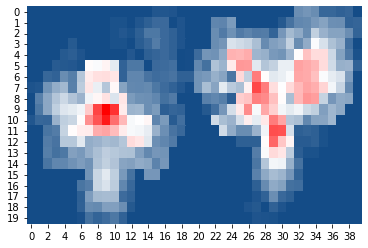

In [56]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# import seanborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

ar_matric = total_lig_spms1[0]

sns.heatmap(ar_matric,cbar=False,cmap=custom_cmap)

<AxesSubplot:>

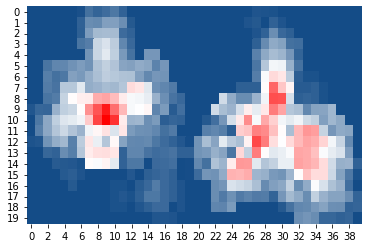

In [57]:
# 现在的，descriptor = np.concatenate([pos_data[::-1], neg_data[::-1]], axis=1) 现在这个才是对应的，y轴从上到下依次减小

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# import seanborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

ar_matric = total_lig_spms[0]

sns.heatmap(ar_matric,cbar=False,cmap=custom_cmap)

## 9. 基于Guided_GradCam的重要性分析

### 9.1 数据的预处理

In [66]:
def min_max(feature_importances):
    min_value = feature_importances.min()
    max_value = feature_importances.max()
    feature_importances = (feature_importances - min_value) / (max_value - min_value)
    return feature_importances

In [67]:
importance_maps = np.load('/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results2D/ensemble_all.npy')
# importance_maps = np.load('/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results2D/vanilla_all.npy')

importance_maps.shape

(3955, 20, 40, 4)

In [68]:
feature_importances = np.average(importance_maps,axis=0)
feature_importances.shape

(20, 40, 4)

In [69]:
feature_importances.min()

0.00044951999880280495

In [70]:
feature_importances.max()

1.0

In [71]:
min_value = feature_importances.min()
max_value = feature_importances.max()
feature_importances = (feature_importances - min_value) / (max_value - min_value)

In [72]:
feature_importances[:100]

array([[[1.86491267e-04, 1.67336291e-03, 2.29059620e-04, 1.06860261e-03],
        [6.25889053e-04, 2.26428789e-03, 2.77371870e-04, 1.63624693e-03],
        [2.05157009e-03, 5.28992686e-03, 1.57861288e-03, 4.00944936e-03],
        ...,
        [1.70874624e-03, 3.38384573e-03, 1.47431445e-03, 1.49035647e-03],
        [1.05005852e-03, 1.93721383e-03, 2.47281630e-04, 7.43320127e-04],
        [3.71850389e-04, 7.98227642e-04, 0.00000000e+00, 1.99786600e-04]],

       [[3.68729669e-04, 1.43481588e-03, 5.62931929e-04, 1.21506009e-03],
        [1.15089334e-03, 3.26076206e-03, 9.09145589e-04, 2.11261078e-03],
        [2.44574648e-03, 5.72707658e-03, 2.21646732e-03, 3.50788229e-03],
        ...,
        [2.74201241e-03, 5.51053398e-03, 1.52549651e-03, 2.37980841e-03],
        [1.68657064e-03, 2.28468369e-03, 5.39050652e-04, 1.03893867e-03],
        [7.88529851e-04, 1.55652399e-03, 2.23473488e-04, 8.84227604e-04]],

       [[1.10895785e-03, 1.73976736e-03, 1.27909074e-03, 1.50387304e-03],
        

In [73]:
lig_importance_dict = {}
for item in lig_smiles_set:
    lig_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = lig_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    lig_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 0])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_lig_importance_dict = {}
for tmp_key in lig_smiles_set:
    # 对应的所有构象的矩阵平均
    new_lig_importance_dict[tmp_key] = min_max(np.average(np.array(lig_importance_dict[tmp_key]),axis=0))

In [74]:
add_importance_dict = {}
for item in add_smiles_set:
    add_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = add_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    add_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 1])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_add_importance_dict = {}
for tmp_key in add_smiles_set:
    # 对应的所有构象的矩阵平均
    new_add_importance_dict[tmp_key] = min_max(np.average(np.array(add_importance_dict[tmp_key]),axis=0))

In [75]:
base_importance_dict = {}
for item in base_smiles_set:
    base_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = base_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    base_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 2])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_base_importance_dict = {}
for tmp_key in base_smiles_set:
    # 对应的所有构象的矩阵平均
    new_base_importance_dict[tmp_key] = min_max(np.average(np.array(base_importance_dict[tmp_key]),axis=0))

In [76]:
ar_importance_dict = {}
for item in ar_smiles_set:
    ar_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = ar_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    ar_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 3])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_ar_importance_dict = {}
for tmp_key in ar_smiles_set:
    # 对应的所有构象的矩阵平均
    new_ar_importance_dict[tmp_key] = min_max(np.average(np.array(ar_importance_dict[tmp_key]),axis=0))

In [77]:
new_lig_importance_dict['CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C=CC=C2'].shape

(20, 40)

### 9.3 特征重要性的矩阵图和四象限图

In [78]:
_, height, width, channel = importance_maps.shape

In [79]:

importances = feature_importances

importances_lig = importances[:, :, 0] 
importances_add = importances[:, :, 1]
importances_base = importances[:, :, 2]
importances_ar = importances[:, :, 3] 

In [80]:
importances_lig.shape

(20, 40)

<AxesSubplot:>

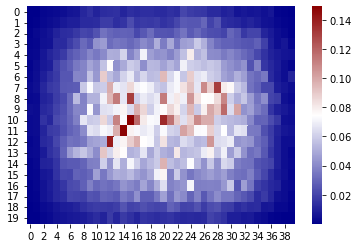

In [81]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_lig, cbar=True, cmap=cmap)

<AxesSubplot:>

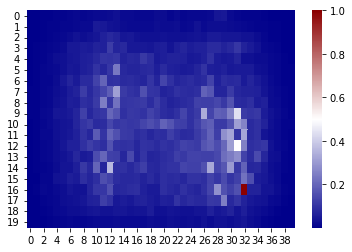

In [82]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_add, cbar=True, cmap=cmap)

<AxesSubplot:>

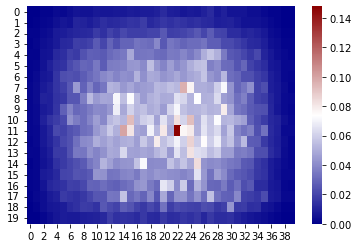

In [83]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_base, cbar=True, cmap=cmap)

<AxesSubplot:>

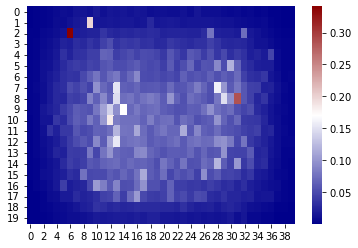

In [84]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_ar, cbar=True, cmap=cmap)

In [85]:
# 划分四个象限，每个象限一个颜色
def devide4(average_colors, row, col):
    # 第一象限
    quadrant1 = average_colors[:row, col:]
    # 第二象限
    quadrant2 = average_colors[:row, :col]
    # 第三象限
    quadrant3 = average_colors[row:, :col]
    # 第四象限
    quadrant4 = average_colors[row:, col:]
    
    return quadrant1, quadrant2, quadrant3, quadrant4

In [86]:

importances = feature_importances

importances_lig = importances[:, :, 0] 
importances_add = importances[:, :, 1]
importances_base = importances[:, :, 2]
importances_ar = importances[:, :, 3] 
num_bins = 20
q_list = np.array([
    *devide4(importances_lig[:, :num_bins], row_lig, col_lig), 
    *devide4(importances_lig[:, num_bins:], row_lig, col_lig), 
    *devide4(importances_add[:, :num_bins], row_add, col_add),
    *devide4(importances_add[:, num_bins:], row_add, col_add),
    *devide4(importances_base[:, :num_bins], row_base, col_base),
    *devide4(importances_base[:, num_bins:], row_base, col_base),
    *devide4(importances_ar[:, :num_bins], row_ar, col_ar),
    *devide4(importances_ar[:, num_bins:], row_ar, col_ar)
])

# 将特征重要性分数按照四个区域对应的像素数量进行平均
num_regions = 32
region_feature_importance = np.zeros(num_regions)

for i in range(num_regions): 
    region_feature_importance[i] = np.mean(q_list[i]) 

# 打印每个区域的特征重要性得分
print('Ligand:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[i]:.4f}")
    
print('Add:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[8+i]:.4f}")
    
print('Base:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[16+i]:.4f}")
    
print('Ar:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[24+i]:.4f}")

Ligand:
Quadrant 1 Feature Importance: 0.0447
Quadrant 2 Feature Importance: 0.0143
Quadrant 3 Feature Importance: 0.0161
Quadrant 4 Feature Importance: 0.0524
Quadrant 5 Feature Importance: 0.0221
Quadrant 6 Feature Importance: 0.0506
Quadrant 7 Feature Importance: 0.0552
Quadrant 8 Feature Importance: 0.0262
Add:
Quadrant 1 Feature Importance: 0.0516
Quadrant 2 Feature Importance: 0.0203
Quadrant 3 Feature Importance: 0.0358
Quadrant 4 Feature Importance: 0.1001
Quadrant 5 Feature Importance: 0.0221
Quadrant 6 Feature Importance: 0.0446
Quadrant 7 Feature Importance: 0.1064
Quadrant 8 Feature Importance: 0.0783
Base:
Quadrant 1 Feature Importance: 0.0251
Quadrant 2 Feature Importance: 0.0047
Quadrant 3 Feature Importance: 0.0066
Quadrant 4 Feature Importance: 0.0366
Quadrant 5 Feature Importance: 0.0188
Quadrant 6 Feature Importance: 0.0333
Quadrant 7 Feature Importance: 0.0516
Quadrant 8 Feature Importance: 0.0277
Ar:
Quadrant 1 Feature Importance: 0.0573
Quadrant 2 Feature Importan

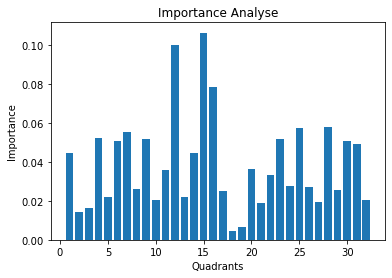

In [87]:
import matplotlib.pyplot as plt
# 创建一个表示象限的列表，从1到24
quadrants = list(range(1, 33))
# 绘制柱状图
plt.bar(quadrants, region_feature_importance)

# 添加横轴和纵轴标签
plt.xlabel("Quadrants")
plt.ylabel("Importance")

# 添加标题
plt.title("Importance Analyse")

# 显示柱状图
plt.show()

In [88]:
region_feature_importance

array([0.04466165, 0.01426535, 0.01609677, 0.05243898, 0.02209423,
       0.05063501, 0.0551826 , 0.02617121, 0.0516171 , 0.02030744,
       0.03576372, 0.10011746, 0.02206899, 0.04455829, 0.10643196,
       0.0783374 , 0.02506958, 0.00468817, 0.00661152, 0.03663531,
       0.01877284, 0.03333139, 0.05157793, 0.02773796, 0.05726985,
       0.0273579 , 0.01938843, 0.05782581, 0.02583112, 0.05097093,
       0.04938382, 0.02050931])

In [89]:
# 对矩阵四个象限的区域进行对应的着色
def assign8(colors, row, col, importances):
    # 第一象限
    colors[:row, col:num_bins] = importances[0]
    # 第二象限
    colors[:row, :col] = importances[1]
    # 第三象限
    colors[row:, :col] = importances[2]
    # 第四象限        
    colors[row:, col:num_bins] = importances[3]
    
    # 第五象限
    colors[:row, num_bins+col:] = importances[4]
    # 第六象限
    colors[:row, num_bins:num_bins+col] = importances[5]
    # 第七象限
    colors[row:, num_bins:num_bins+col] = importances[6]
    # 第八象限
    colors[row:, num_bins+col:] = importances[7]
    
    return colors

In [90]:
lig_metric = assign8(np.zeros([height, width]), row_lig, col_lig, region_feature_importance[:8])
add_metric = assign8(np.zeros([height, width]), row_add, col_add, region_feature_importance[8:16])
base_metric = assign8(np.zeros([height, width]), row_base, col_base, region_feature_importance[16:24])
ar_metric = assign8(np.zeros([height, width]), row_ar, col_ar, region_feature_importance[24:])

<AxesSubplot:>

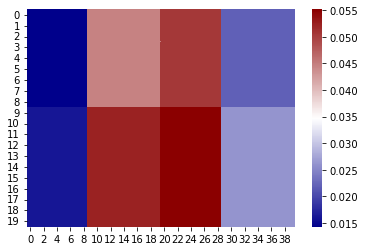

In [91]:
sns.heatmap(lig_metric,cbar=True,cmap=cmap) 

<AxesSubplot:>

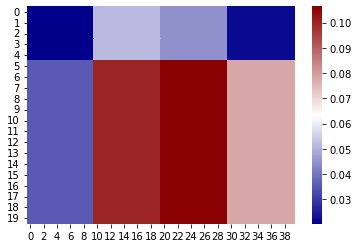

In [92]:
sns.heatmap(add_metric,cbar=True,cmap=cmap) 

<AxesSubplot:>

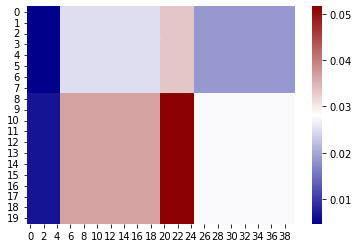

In [93]:
sns.heatmap(base_metric,cbar=True,cmap=cmap) 

<AxesSubplot:>

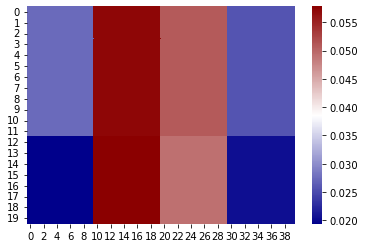

In [94]:
sns.heatmap(ar_metric,cbar=True,cmap=cmap) 

### 9.4 特征重要性回溯到三维表面

In [95]:
%matplotlib notebook  

In [96]:
num_bins = 20

#### Ligand

In [90]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Doyle/Jishe_81/lig_projected_points.npy', allow_pickle=True)
origin_cat = projected_points_list[0]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']
    
    
# 确定每个数据点所在的象限
samples = origin_cat
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Cat',
    title_x=0.5  # 设置标题在X轴中央
    
)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()
    

color_origin = []

# Save the plot as an HTML file
# fig.write_html("cat_point_plot.html")

In [1]:
for i in new_lig_desc_dict.values():
    print(i.shape)

NameError: name 'new_lig_desc_dict' is not defined

In [94]:
import math
import sympy as sp
from scipy.optimize import newton

# _, height, width, channel = react_spms_std.shape
importances = feature_importances.reshape(height, width, channel)

# cat
importances_lig_pos = importances[:, :num_bins, 0]  # 为了从上往下y坐标依次增大
importances_lig_neg = importances[:, num_bins:, 0]
x_cor_lig, y_cor_lig, z_cor_lig, color_lig = [], [], [], []

for lig_matric in new_lig_desc_dict.values():
    # for cat_matric in [cat_matric]:

    lig_z_pos = lig_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    lig_z_neg = lig_matric[::-1, num_bins:]

    for y_index in range(importances_lig_pos.shape[0]):
        y_project = y_min_mid_lig + y_index * y_step_lig
        for x_index in range(importances_lig_pos.shape[1]):
            x_project = x_min_mid_lig + x_index * x_step_lig
            z_project = lig_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_lig_pos[y_index, x_index]

            if (importance_color <= 0.04):
                continue

            x_cor_lig.append(x_cor)
            y_cor_lig.append(y_cor)
            z_cor_lig.append(z_cor)
            color_lig.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)

print('+++++++++++++++++++++++++++++++++++')
for lig_matric in new_lig_desc_dict.values():
    # for cat_matric in [cat_matric]:

    lig_z_pos = lig_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    lig_z_neg = lig_matric[::-1, num_bins:]

    for y_index in range(importances_lig_neg.shape[0]):
        y_project = y_min_mid_lig + y_index * y_step_lig
        for x_index in range(importances_lig_neg.shape[1]):
            x_project = x_min_mid_lig + x_index * x_step_lig
            z_project = lig_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_lig_pos[y_index, x_index]

            if (importance_color <= 0.04):
                continue

            x_cor_lig.append(x_cor)
            y_cor_lig.append(y_cor)
            z_cor_lig.append(-z_cor)
            color_lig.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)

theta/2:  0.7703567782521243
theta/2:  0.7708893305019633
theta/2:  0.772274360885249
theta/2:  0.7723096211573351
theta/2:  0.772454652888091
theta/2:  0.7680703973826628
theta/2:  0.7523879056624726
theta/2:  0.7387754723469528
theta/2:  0.7405685860452188
theta/2:  0.7720808013922996
theta/2:  0.7836536611157531
theta/2:  0.7835767377114494
theta/2:  0.7709304749107443
theta/2:  0.7612913328728897
theta/2:  0.7714597765549925
theta/2:  0.7483175340726862
theta/2:  0.7120045133438124
theta/2:  0.7148935829323575
theta/2:  0.7375807333278291
theta/2:  0.7516707852005161
theta/2:  0.7713106186092876
theta/2:  0.7836027328245957
theta/2:  0.7834992650796604
theta/2:  0.7550686935503745
theta/2:  0.7833070330786179
theta/2:  0.7692275696457247
coordinate 0.4118919372231026 -4.601219611931223 0.14945606601363692 0.04264169698474697
theta/2:  0.7695003577983273
coordinate 0.964978596089636 -4.598789175729821 0.14945606601363692 0.045582814541970794
theta/2:  0.7485176647131894
theta/2:  0.

theta/2:  0.3303424638068796
coordinate 2.633361361057052 -1.1421850639522948 3.6932397785652245 0.059868224370641834
theta/2:  0.3811746974010715
coordinate 3.4598028260863156 -1.0998332830986448 3.801741156874318 0.11138087539814946
theta/2:  0.41741014845226937
coordinate 4.251842217217933 -1.066705456709407 3.9703990633365795 0.07303439141208791
theta/2:  0.6401962734063306
coordinate 3.9622754667621494 -0.8209992361637692 1.2092886474011757 0.14927986312878141
theta/2:  0.6192312529194007
coordinate 4.796422175497875 -0.8464721700893981 1.6809925721596881 0.11766665745295557
theta/2:  0.7469034651452197
coordinate 4.472190557813085 -0.6873343370794496 0.3490438898673497 0.08097435952030353
theta/2:  0.7161123379017266
coordinate 5.336733182323965 -0.7264046429299106 0.7511531217027761 0.0733362576896797
theta/2:  0.6901374220602755
theta/2:  0.6632755987994746
theta/2:  0.4933968864783034
theta/2:  0.3939049148250798
theta/2:  0.3270867242218543
theta/2:  0.2520058221365901
theta/

theta/2:  0.7272883284024761
coordinate 3.4374557918257556 -3.7563112483513224 0.5944409585164192 0.05988093724575424
theta/2:  0.7026746085203337
coordinate 4.212147681829377 -3.9203535342616345 0.9608062295570706 0.05687247767587674
theta/2:  0.720414653782604
coordinate 4.6909928638126965 -3.8022342884987377 0.7892430205167327 0.04150988878365592
theta/2:  0.7407853380042033
coordinate 5.106870270553276 -3.6659311860373727 0.5624038840260197 0.05379975137565851
theta/2:  0.7478550147579472
theta/2:  0.74440808930283
theta/2:  0.7164230378642982
theta/2:  0.5524488200681008
theta/2:  0.451517842371357
theta/2:  0.4234857604709921
theta/2:  0.40812148521369707
coordinate -0.2312883977701379 -4.7523480827209 4.473150401875107 0.05699820420687949
theta/2:  0.4179144163697396
coordinate 0.6665385566023222 -4.711732867346017 4.301355195448675 0.044521566243124894
theta/2:  0.5085409404913661
coordinate 1.427046676833633 -4.303578314145096 2.8030502503168107 0.08972818000987123
theta/2:  0

theta/2:  0.5904418364066965
theta/2:  0.4662112984251494
theta/2:  0.39408897189548514
coordinate -2.977232472739791 1.7024206894139617 3.4105847568210663 0.04529492913626929
theta/2:  0.35850317089501965
coordinate -2.1216819929643926 1.7509810467037477 3.1554828292806887 0.05304918925710499
theta/2:  0.41810717092614136
coordinate -1.124969355461929 1.6676148043143055 1.8168746282114148 0.05817148062837744
theta/2:  0.3749206469782992
coordinate -0.2377170810006398 1.7290367888830986 1.8740486114439772 0.050467194785982994
theta/2:  0.4055054407300839
coordinate 0.6738013267088516 1.686074247155881 1.7250164326465531 0.04140378043901416
theta/2:  0.36752887829169173
coordinate 1.629005519998277 1.739015839723151 2.6356671704545613 0.09107148172392274
theta/2:  0.46900428689266643
coordinate 2.341743153871538 1.588858577734153 2.075416223120322 0.06298245462723509
theta/2:  0.5397379960075832
coordinate 2.955001782917112 1.469444616851015 1.7658871824068016 0.07939749789439435
theta/

theta/2:  0.5078492360665885
coordinate 4.703658153568186 -1.807686433541495 3.124929975019828 0.06362051600213928
theta/2:  0.5745800995252045
coordinate 5.096607851635642 -1.6682677750113257 2.405365212008255 0.09827409255436304
theta/2:  0.6653104401856836
coordinate 5.140621632976632 -1.465388029612477 1.3091038840260196 0.08685128616519427
theta/2:  0.7079197382632035
coordinate 5.4127372504539455 -1.3664990273295923 0.8720478180123828 0.060475978215012514
theta/2:  0.7397502084687207
theta/2:  0.7209835289575898
theta/2:  0.6316927525560498
theta/2:  0.5213922552497325
theta/2:  0.4567527750937043
theta/2:  0.3912266754967002
theta/2:  0.2638215658303367
theta/2:  0.17913241136087657
coordinate -1.3042810639236835 -1.2359652851773815 4.799048817149404 0.06759691954654508
theta/2:  0.10315256231284387
coordinate -0.2716214628743499 -1.2629552514311086 6.172671906117191 0.059149606426060104
theta/2:  0.10863895755705232
coordinate 0.7885996164798107 -1.2614830775052683 6.7388684869

theta/2:  0.7673090412722389
coordinate 0.41342198658324364 -3.487745592349456 0.1271193467079823 0.04374306024448381
theta/2:  0.7678292215675678
coordinate 0.9681026941141386 -3.4842459686501908 0.1271193467079823 0.05699061150076408
theta/2:  0.6927758687424629
coordinate 1.7425350630860668 -3.9859688928155115 0.8152 0.07576140609709885
theta/2:  0.6904042148246594
coordinate 2.3869192983441536 -4.001654658439667 0.8960492726707944 0.042983990026049676
theta/2:  0.6827440494794593
coordinate 3.0626622258197678 -4.052218366231525 1.0577478180123827 0.04993673327207605
theta/2:  0.6758375408876307
coordinate 3.7498378048906424 -4.097669549525293 1.2369641255580952 0.05988093724575424
theta/2:  0.715119754751459
coordinate 4.123185076328437 -3.837553762924733 0.7969717488838101 0.05687247767587674
theta/2:  0.7468054096572334
coordinate 4.473002546097309 -3.6255445589167326 0.4453038116628577 0.04150988878365592
theta/2:  0.7623971597772187
theta/2:  0.7307087417311452
theta/2:  0.6982

theta/2:  0.6974759650341029
theta/2:  0.6738535017785127
theta/2:  0.6179813653619126
theta/2:  0.5767914265975296
theta/2:  0.4278625307173169
theta/2:  0.31979060316928376
theta/2:  0.241127391539163
theta/2:  0.22676306062369977
theta/2:  0.19254692959493708
coordinate -0.26447932877340014 0.8725459351142887 2.249391346820455 0.04664345785512113
theta/2:  0.2785676963662622
coordinate 0.7376427216548122 0.8372277514528457 1.7911500463615624 0.04792306729415145
theta/2:  0.4104654708515496
coordinate 1.5726552471214716 0.7614953059989215 1.6273558159022938 0.05037896058467651
theta/2:  0.41400178951958844
coordinate 2.46675117373156 0.7591437969564654 2.3698643911645045 0.1412327111312082
theta/2:  0.4672987731324725
coordinate 3.2006546940897302 0.7219165826928139 2.4235616496928016 0.06954244173389745
theta/2:  0.561487994389447
coordinate 3.6455800901022086 0.648943231475715 1.778755028396004 0.07770148506939205
theta/2:  0.5301776943497876
coordinate 4.5851771875423175 0.6741039

theta/2:  0.17570311974484384
coordinate -1.9661468405411466 -1.327719761275287 -6.471121211047134 0.06695863439395225
theta/2:  0.06336927981987098
coordinate 0.7947805919862813 -0.18464549282389606 -6.4035282308904975 0.06427082461495526
theta/2:  0.25402720442783194
coordinate 1.7523651675358862 -0.1736809628510735 -3.162587031028323 0.07279404976151348
theta/2:  0.6679937628099494
coordinate 1.8138589690295501 -0.11426050122449105 -0.43477422134396093 0.06943381513756554
theta/2:  0.6781332602591568
coordinate 2.4351879065013216 -0.11242802397855821 -0.5311503568243314 0.09831590665404302
theta/2:  0.7122846647142751
coordinate 2.9146959199046596 -0.10620066108768988 -0.42955606601363683 0.1479702922917937
theta/2:  0.7655723113156556
coordinate 3.2023789108337275 -0.09636900943485138 -0.12710388402601958 0.07836953738247274
theta/2:  0.7071424494887507
theta/2:  0.6880719310471665
theta/2:  0.6564742188171203
theta/2:  0.19156731646947278
theta/2:  0.07642605161147015
coordinate -

theta/2:  0.77791327485225
theta/2:  0.7606411444840053
theta/2:  0.7641854756243786
coordinate -1.8200896181429844 1.0407511844927355 -0.08900404400909116 0.04529492913626929
theta/2:  0.503186462609022
coordinate -1.856924745754198 1.5324822691396354 -1.524338475334857 0.05304918925710499
theta/2:  0.31486346276839616
coordinate -1.217855775733429 1.8053063501439337 -2.9884635074529067 0.05817148062837744
theta/2:  0.2230081656677383
coordinate -0.2611038904245407 1.8991409046593382 -4.00920388402602 0.050467194785982994
theta/2:  0.23939471751608582
coordinate 0.7531155735347099 1.884544780983472 -3.9097690624269004 0.04140378043901416
theta/2:  0.38964941816879184
coordinate 1.6005875352201837 1.708678726032973 -2.369988293029449 0.09107148172392274
theta/2:  0.7043155922875942
coordinate 1.7090854009755665 1.1596041158189325 -0.33789428250571374 0.06298245462723509
theta/2:  0.7660036841829398
theta/2:  0.7482291431633509
theta/2:  0.7590220372412246
theta/2:  0.6128148624129657
t

theta/2:  0.5310963549620762
coordinate 2.9854547480307083 -2.571464123004359 -2.1967808947782044 0.11370196098183193
theta/2:  0.5718183815794291
coordinate 3.597969925055866 -2.445791173511515 -1.980316296527679 0.06720139321133652
theta/2:  0.718533903674724
coordinate 3.4909665203494034 -1.9599195232345386 -0.5385986014706916 0.13063048719602233
theta/2:  0.7450222364159222
coordinate 3.9082535015642286 -1.868841524225944 -0.3505867692203043 0.06093358860913828
theta/2:  0.748937815679895
coordinate 4.455341567332876 -1.8553387381159256 -0.35255606601363687 0.06858916597426896
theta/2:  0.7523597002279828
coordinate 4.998654422627565 -1.8435320916674582 -0.35255606601363687 0.06471024054656153
theta/2:  0.7808874192485942
coordinate 5.272438164294803 -1.7449464560555057 -0.05010388402601962 0.06831171959813552
theta/2:  0.7650335513944566
theta/2:  0.7371547496735933
theta/2:  0.6882458202170851
theta/2:  0.5808832507182785
theta/2:  0.5130973658065269
theta/2:  0.4403300500227517


coordinate 1.6694132796746726 -1.1392653262857593 -2.5610413200555278 0.08577477570217916
theta/2:  0.5158593650250166
coordinate 2.2268916883876355 -0.9658843116369245 -1.4519776459857279 0.059868224370641834
theta/2:  0.4776537055663091
coordinate 3.166955638489368 -1.0067403815747473 -2.34984739776044 0.11138087539814946
theta/2:  0.5295039792738137
coordinate 3.7899159309090344 -0.9508170335200764 -2.1948030780419967 0.07303439141208791
theta/2:  0.7264343955326298
coordinate 3.4426804726865137 -0.7133370867677786 -0.4165431864335454 0.14927986312878141
theta/2:  0.7662139643380006
coordinate 3.755255736909159 -0.6627272071879708 -0.14638152801713056 0.11766665745295557
theta/2:  0.7846389244279325
theta/2:  0.7844948755076184
theta/2:  0.725544584373648
theta/2:  0.5430473860675243
theta/2:  0.403194279338623
theta/2:  0.18774610641964323
coordinate -1.3001190661732778 -0.17893067539094196 -3.3292496202089774 0.041166366447731306
theta/2:  0.18774610641964323
coordinate -1.4397779

In [95]:
# 根据所有的分子结构将特征重要性回溯到三维表面
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_lig,
    y=y_cor_lig,
    z=z_cor_lig,
    mode='markers',
    marker=dict(
        size=4,
        color=color_lig,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend'),
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
         showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of CPA',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
os.makedirs('/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D', exist_ok=True)
fig.write_html("/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D/lig_importance_plot_all.html")

In [157]:
# 根据每个分子结构分别将特征重要性回溯到三维表面
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/lig_grad"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in lig_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_lig_importance_dict[tmp_key]
    # cat
    importances_lig_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_lig_neg = importances[:, num_bins:]

    lig_matric = new_lig_desc_dict[tmp_key]

    x_cor_lig, y_cor_lig, z_cor_lig, color_lig = [], [], [], []

    print(tmp_key)

    lig_z_pos = lig_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    lig_z_neg = lig_matric[::-1, num_bins:]

    for y_index in range(importances_lig_pos.shape[0]):
        y_project = y_min_mid_lig + y_index * y_step_lig
        for x_index in range(importances_lig_pos.shape[1]):
            x_project = x_min_mid_lig + x_index * x_step_lig
            z_project = lig_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_lig_pos[y_index, x_index]

            x_cor_lig.append(x_cor)
            y_cor_lig.append(y_cor)
            z_cor_lig.append(z_cor)
            color_lig.append(importance_color)

    #             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    for y_index in range(importances_lig_neg.shape[0]):
        y_project = y_min_mid_lig + y_index * y_step_lig
        for x_index in range(importances_lig_neg.shape[1]):
            x_project = x_min_mid_lig + x_index * x_step_lig
            z_project = lig_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_lig_pos[y_index, x_index]

            x_cor_lig.append(x_cor)
            y_cor_lig.append(y_cor)
            z_cor_lig.append(-z_cor)
            color_lig.append(importance_color)

    #             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go

    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_cat 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_lig,
        y=y_cor_lig,
        z=z_cor_lig,
        mode='markers',
        marker=dict(
            size=4,
            color=color_lig,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )


    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
            showlegend=False  # 不显示箭头的图例
        )
        return arrow


    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')

    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of CPA',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
    #     fig.show()

    # Save the plot as an HTML file
    fig.write_html("{}/{}.html".format(path, index))

    index = index + 1

CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2
CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC
CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C=CC=C2
CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC


#### Add

In [167]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Doyle/Jishe_81/add_projected_points.npy', allow_pickle=True)
origin_cat = projected_points_list[0]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']
    
    
# 确定每个数据点所在的象限
samples = origin_cat
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Cat',
    title_x=0.5  # 设置标题在X轴中央
    
)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()
    

color_origin = []

# Save the plot as an HTML file
# fig.write_html("cat_point_plot.html")

In [97]:
import math
import sympy as sp
from scipy.optimize import newton

# _, height, width, channel = react_spms_std.shape
importances = feature_importances.reshape(height, width, channel)

# cat
importances_add_pos = importances[:, :num_bins, 1]  # 为了从上往下y坐标依次增大
importances_add_neg = importances[:, num_bins:, 1]
x_cor_add, y_cor_add, z_cor_add, color_add = [], [], [], []

for add_matric in new_add_desc_dict.values():
    # for cat_matric in [cat_matric]:

    add_z_pos = add_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    add_z_neg = add_matric[::-1, num_bins:]

    for y_index in range(importances_add_pos.shape[0]):
        y_project = y_min_mid_add + y_index * y_step_add
        for x_index in range(importances_add_pos.shape[1]):
            x_project = x_min_mid_add + x_index * x_step_add
            z_project = add_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_add_pos[y_index, x_index]

            if (importance_color <= 0.15):
                continue

            x_cor_add.append(x_cor)
            y_cor_add.append(y_cor)
            z_cor_add.append(z_cor)
            color_add.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)

print('+++++++++++++++++++++++++++++++++++')
for add_matric in new_add_desc_dict.values():
    # for cat_matric in [cat_matric]:

    add_z_pos = add_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    add_z_neg = add_matric[::-1, num_bins:]

    for y_index in range(importances_add_neg.shape[0]):
        y_project = y_min_mid_add + y_index * y_step_add
        for x_index in range(importances_add_neg.shape[1]):
            x_project = x_min_mid_add + x_index * x_step_add
            z_project = add_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_add_pos[y_index, x_index]

            if (importance_color <= 0.15):
                continue

            x_cor_add.append(x_cor)
            y_cor_add.append(y_cor)
            z_cor_add.append(-z_cor)
            color_add.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)

theta/2:  0.7422150461950126
theta/2:  0.7351042634794135
theta/2:  0.7297572303855421
theta/2:  0.7188671212129054
theta/2:  0.7279279127329978
theta/2:  0.7515857938121744
theta/2:  0.7180894873552987
theta/2:  0.7214071981560976
theta/2:  0.6923342286179106
theta/2:  0.6887924448403596
theta/2:  0.7121182032178206
theta/2:  0.7213907406962387
theta/2:  0.7475780272308247
theta/2:  0.6944246670988661
theta/2:  0.6662007791687099
theta/2:  0.661677283938128
theta/2:  0.5825411167917969
theta/2:  0.5897967252649432
coordinate 0.6531029518401554 -6.695444355792439 2.774721729085913 0.19828552157742285
theta/2:  0.7277577257725174
theta/2:  0.6584565792950178
theta/2:  0.5986377431261516
theta/2:  0.6398295182157167
theta/2:  0.5430024844864957
theta/2:  0.5333577840803846
theta/2:  0.5393683314466103
theta/2:  0.5376074238305337
theta/2:  0.5547300060770051
coordinate 1.2776479231499986 -6.221977038710204 3.157570804040356 0.1841388791173137
theta/2:  0.6187213376932991
coordinate 1.719

theta/2:  0.6529808237646783
theta/2:  0.6217084215129266
theta/2:  0.36905062818139883
theta/2:  0.21770372485613437
theta/2:  0.18427917680887604
coordinate 0.11894377951363075 -0.9916555085838242 2.5860926581146564 0.19943806272910763
theta/2:  0.27747145561353925
theta/2:  0.4796541515478437
coordinate 1.3916445469582392 -0.8075915818203963 1.1281274447087264 0.3632130414662263
theta/2:  0.7162689580044622
theta/2:  0.595008532011592
theta/2:  0.34878249010084966
theta/2:  0.1692947597923957
theta/2:  0.1692947597923957
theta/2:  0.21817160101356195
coordinate 0.901333247297828 0.0547384005434035 1.936421535413226 0.15592670585584728
theta/2:  0.480769416111121
theta/2:  0.7117118939726569
theta/2:  0.7121104593765039
theta/2:  0.5640888311432668
theta/2:  0.394834361103353
theta/2:  0.3291231923683434
theta/2:  0.415822006179322
theta/2:  0.5794093987520579
coordinate 1.23810852490838 0.7989170303594989 0.643893270152924 0.15670196283793877
theta/2:  0.7172254301989924
theta/2:  0

theta/2:  0.4153792177894521
theta/2:  0.5794093987520579
coordinate 1.23810852490838 0.7989170303594989 0.643893270152924 0.15670196283793877
theta/2:  0.7172254301989924
theta/2:  0.7248054903823646
theta/2:  0.7142127892453707
theta/2:  0.6442844928691579
theta/2:  0.5877283870580069
theta/2:  0.6665678009611542
theta/2:  0.7174540048867574
theta/2:  0.6422614529954854
theta/2:  0.6128607974462502
theta/2:  0.6261918252327432
theta/2:  0.6311875735464809
theta/2:  0.6306093756847296
theta/2:  0.6458492734893313
theta/2:  0.6398390508647085
theta/2:  0.6374924937227332
theta/2:  0.6456093444095924
theta/2:  0.6319913027091711
theta/2:  0.6505896410025056
theta/2:  0.6178321726555133
theta/2:  0.6624252217705227
theta/2:  0.622027986951324
theta/2:  0.6413090015780888
theta/2:  0.6209725748586025
theta/2:  0.641270694056639
theta/2:  0.6171035806950027
theta/2:  0.6396906919518364
theta/2:  0.6172610476397816
theta/2:  0.6451299383679308
theta/2:  0.6593833636578408
theta/2:  0.601687

coordinate 1.5426513625934304 -2.546553267031524 0.5789991044291417 0.15913629192778644
theta/2:  0.7285933580616504
theta/2:  0.600125431763737
theta/2:  0.4997458659797349
theta/2:  0.42644762706113176
theta/2:  0.40556648340764495
theta/2:  0.4354052455626954
theta/2:  0.5241316602370439
coordinate 1.3253286816931367 -2.393412814482691 1.5756632299872368 0.1616802880620445
theta/2:  0.6496716008202945
theta/2:  0.6384308320739885
theta/2:  0.44658260461822047
theta/2:  0.35792387676590426
theta/2:  0.3353394102135091
coordinate 0.10974704852567242 -1.881170748098864 2.3751766384154487 0.1519238134738854
theta/2:  0.3702792384331972
coordinate 0.821800016386024 -1.833378758958989 2.1979064164207824 0.20282108437368662
theta/2:  0.5211568604062203
theta/2:  0.6516214540338943
theta/2:  0.6191403946106407
theta/2:  0.3672964596167124
theta/2:  0.22172412666058058
theta/2:  0.1858963709696608
coordinate 0.11887177171430248 -0.9910551667151123 2.559860257563952 0.19943806272910763
theta/

theta/2:  0.48903552470992334
theta/2:  0.45124099127009754
theta/2:  0.4435303061978463
theta/2:  0.46260363425770096
theta/2:  0.5186849572259635
theta/2:  0.6486169805193465
theta/2:  0.7381160302133555
theta/2:  0.5638832787001223
theta/2:  0.44575008328878896
theta/2:  0.37112215296991563
theta/2:  0.365983904456106
coordinate 0.10731387756222786 -3.729001638059333 4.152120343466314 0.1792805387294839
theta/2:  0.37479167043985007
theta/2:  0.485274880958812
coordinate 1.3834750290141473 -3.3462037238767044 2.478517502709009 0.199364968041348
theta/2:  0.6391026216349582
coordinate 1.669006533965655 -2.7551358296679203 0.9703545739954288 0.15913629192778644
theta/2:  0.7302938050287473
theta/2:  0.5831786955365743
theta/2:  0.40413636373420936
theta/2:  0.30170877718098577
theta/2:  0.29209573830911834
theta/2:  0.31467402066151845
theta/2:  0.4461672775241099
coordinate 1.4389523055861424 -2.5986058667495917 2.3945082024998774 0.1616802880620445
theta/2:  0.6127396572267546
theta

theta/2:  0.1552028272387369
theta/2:  0.2043543521150124
coordinate 0.9066910224178764 0.0550637807969578 2.097363520491754 0.15592670585584728
theta/2:  0.47929163469452807
theta/2:  0.7117118939726569
theta/2:  0.7121104593765039
theta/2:  0.5640888311432668
theta/2:  0.38849538701803377
theta/2:  0.3279270583061152
theta/2:  0.4219988777411343
theta/2:  0.5794093987520579
coordinate 1.23810852490838 0.7989170303594989 0.643893270152924 0.15670196283793877
theta/2:  0.7172254301989924
theta/2:  0.7248054903823646
theta/2:  0.7142127892453707
theta/2:  0.6442844928691579
theta/2:  0.5877283870580069
theta/2:  0.6665678009611542
theta/2:  0.7174540048867574
theta/2:  0.5755097629713164
theta/2:  0.5480565611981019
theta/2:  0.5885568818801239
coordinate 0.6541862589102284 -6.70655014269399 2.7988959390353294 0.19828552157742285
theta/2:  0.5762703026306224
theta/2:  0.5721383105390919
theta/2:  0.5537538915819131
theta/2:  0.5417135983256116
theta/2:  0.5569348164424662
theta/2:  0.59

theta/2:  0.7069115681814011
theta/2:  0.6708411291802021
theta/2:  0.6949475208201954
theta/2:  0.7210531784496992
theta/2:  0.7178877524268032
coordinate 0.5364637556601379 -4.270296080103746 0.584668168963271 0.24947096511919686
theta/2:  0.7019910415244013
theta/2:  0.6693206851567451
theta/2:  0.6622189720548345
theta/2:  0.5526741837157074
theta/2:  0.5948076792804778
theta/2:  0.6887187823348815
coordinate 1.0539812229042806 -3.841004240028513 0.7798892572275046 0.20210331320422253
theta/2:  0.688421282865716
coordinate 1.5450466608069156 -3.8428854306107483 0.8135548930113502 0.16530748674996026
theta/2:  0.7432073950722025
theta/2:  0.6301560024487743
theta/2:  0.5172070578811495
theta/2:  0.4796106371472923
theta/2:  0.47129104499756824
theta/2:  0.4884234271748207
theta/2:  0.5282567102600101
theta/2:  0.6461542081614571
theta/2:  0.7366636718636297
theta/2:  0.5317963371106522
theta/2:  0.43097349101947174
theta/2:  0.41293635960166475
theta/2:  0.40601679254739953
coordina

theta/2:  0.5716850266460713
coordinate 1.250581196019285 -3.024774114001824 -1.4909305046737797 0.199364968041348
theta/2:  0.6662153691802964
coordinate 1.6012332334487378 -2.643258107952031 -0.7509285988423512 0.15913629192778644
theta/2:  0.751086347502692
theta/2:  0.7442103422930104
theta/2:  0.5968387291875159
theta/2:  0.4904066910895299
theta/2:  0.44000099559476985
theta/2:  0.4248993200217986
theta/2:  0.45273399499347794
theta/2:  0.5032865954746094
coordinate 1.3568757167885805 -2.450383646774581 -1.7725957270874848 0.1616802880620445
theta/2:  0.6363944378951772
theta/2:  0.6202971204114751
theta/2:  0.3983368390930893
theta/2:  0.30977344974779214
theta/2:  0.31807758202304026
coordinate 0.11103848682163199 -1.9033072517950473 -2.5813472889017004 0.1519238134738854
theta/2:  0.31701974213107226
coordinate 0.8537384567381698 -1.904631201120535 -2.8385201541819347 0.20282108437368662
theta/2:  0.43368040058271334
theta/2:  0.642764425681221
theta/2:  0.5532960148455448
the

theta/2:  0.7291373597791065
theta/2:  0.6640052373545992
theta/2:  0.6939714809786339
theta/2:  0.6644777055205394
theta/2:  0.7586229797058708
coordinate 1.3647105935516644 -3.3943482679163135 -0.19609720375326783 0.16530748674996026
theta/2:  0.7225359803060796
theta/2:  0.6427500889741077
theta/2:  0.5753933561951591
theta/2:  0.5554063807135371
theta/2:  0.5764234635254337
theta/2:  0.6423692249817605
theta/2:  0.7235066812233509
theta/2:  0.7170209108914951
theta/2:  0.6411760170750643
theta/2:  0.5436711064884164
theta/2:  0.49986052448653445
theta/2:  0.48030386489394555
coordinate 0.09680079090077033 -3.363687120755622 -2.3528624650061722 0.1792805387294839
theta/2:  0.5082709442302903
theta/2:  0.6668425819445242
coordinate 1.599653985874039 -2.6406511429771067 -0.7460876745961246 0.15913629192778644
theta/2:  0.7518620427283546
theta/2:  0.7451303603608205
theta/2:  0.597465683356421
theta/2:  0.42585151182802106
theta/2:  0.3871522681551735
theta/2:  0.3589271055613176
thet

theta/2:  0.7508134031998702
theta/2:  0.7438867256177623
theta/2:  0.5966179997666909
theta/2:  0.49023506215635154
theta/2:  0.44344657516548136
theta/2:  0.4220199656252934
theta/2:  0.44803237497432646
theta/2:  0.49601968327359935
coordinate 1.3676831203314597 -2.469900751088484 -1.844718773582725 0.1616802880620445
theta/2:  0.6361517060799292
theta/2:  0.6090575612433083
theta/2:  0.4306168128757536
theta/2:  0.35120183203210037
theta/2:  0.3363517485753366
coordinate 0.10966951188876 -1.879841695015204 -2.3636538990290763 0.1519238134738854
theta/2:  0.37548852710690306
coordinate 0.8184575060508011 -1.8259218505530395 -2.1436854460306747 0.20282108437368662
theta/2:  0.4630889812627303
theta/2:  0.6449023016023283
theta/2:  0.5569489015563962
theta/2:  0.31919887277937814
theta/2:  0.20740866596870747
theta/2:  0.16601080666139587
coordinate 0.11971532103619932 -0.9980879878953514 -2.9155597865302267 0.19943806272910763
theta/2:  0.2494367053064714
theta/2:  0.4436876989843477

theta/2:  0.06604416561473307
theta/2:  0.10203077887508862
coordinate 0.9358245195484532 0.05683307205515175 -4.530490188420064 0.15592670585584728
theta/2:  0.25731537371935737
theta/2:  0.7117118939726571
theta/2:  0.7121104593765039
theta/2:  0.29425782967309916
theta/2:  0.2164298127606311
theta/2:  0.15391373861783544
theta/2:  0.2510152683889737
theta/2:  0.32191620324275494
coordinate 1.591198148468445 1.0267559538708568 -2.5232053325167474 0.15670196283793877
theta/2:  0.7172254301989924
theta/2:  0.7248054903823646
theta/2:  0.4052920482524751
theta/2:  0.36206892943398034
theta/2:  0.36350464082532646
theta/2:  0.3813743404492046
theta/2:  0.44234570620859437
theta/2:  0.41591219199234764
theta/2:  0.7601750360040773
theta/2:  0.7600200741722943
theta/2:  0.7600546654160346
theta/2:  0.7581595099861104
theta/2:  0.7255613861024341
theta/2:  0.7254520893748356
theta/2:  0.7256542434862192
theta/2:  0.7579040050672151
theta/2:  0.758287663645717
coordinate 1.3655780532810677 -

theta/2:  0.5093923590018882
theta/2:  0.5444267734036166
theta/2:  0.4898612103637354
theta/2:  0.5252320963950374
theta/2:  0.35733176515096693
theta/2:  0.39224854764315886
theta/2:  0.3010910013417219
theta/2:  0.21201658763791312
theta/2:  0.19729918137561034
coordinate 0.11834706576937319 -2.028583376404866 -4.879527311945154 0.1519238134738854
theta/2:  0.30298232407438325
coordinate 0.8614510433686323 -1.9218374462202907 -3.0393817608852243 0.20282108437368662
theta/2:  0.3516192898092209
theta/2:  0.6436559574478741
theta/2:  0.5617520229305175
theta/2:  0.49753910672641455
theta/2:  0.44678042126215795
theta/2:  0.5251302375131504
theta/2:  0.420878314348605
theta/2:  0.32554512048562645
theta/2:  0.273264250029601
theta/2:  0.2092672827083806
theta/2:  0.1534221941400377
theta/2:  0.10459851134743153
theta/2:  0.09284156820432085
coordinate 0.12201838695660376 -1.0172890593253963 -5.454336226448565 0.19943806272910763
theta/2:  0.1347291198266826
theta/2:  0.2945883521585849

theta/2:  0.7565805217741758
coordinate 0.5000532422352381 -3.9804653671945647 -0.2314748523965529 0.24947096511919686
theta/2:  0.7763953676616155
theta/2:  0.726204821544857
theta/2:  0.6592560485673925
theta/2:  0.6808852618018516
theta/2:  0.6597435139854825
theta/2:  0.7555049883936386
coordinate 1.3727755551245633 -3.414407677197029 -0.2202786619307085 0.16530748674996026
theta/2:  0.7192973262844569
theta/2:  0.638887220196766
theta/2:  0.5711599741558825
theta/2:  0.5514147177113771
theta/2:  0.5722044482738966
theta/2:  0.6389805646436875
theta/2:  0.7203126052064341
theta/2:  0.7135317654708427
theta/2:  0.6382428630461391
theta/2:  0.5484164779530707
theta/2:  0.4996103253896688
theta/2:  0.4871489106481961
coordinate 0.09610707659412493 -3.3395815544990497 -2.2685438210535493 0.1792805387294839
theta/2:  0.5041190083871009
theta/2:  0.6637228265274597
coordinate 1.6075043800092892 -2.653610290660999 -0.7702691327735652 0.15913629192778644
theta/2:  0.7480096338206437
theta/

In [98]:
%matplotlib inline

In [103]:
%matplotlib notebook 
# plt.close('all')  # 关闭所有现有图形窗口

<IPython.core.display.Javascript object>


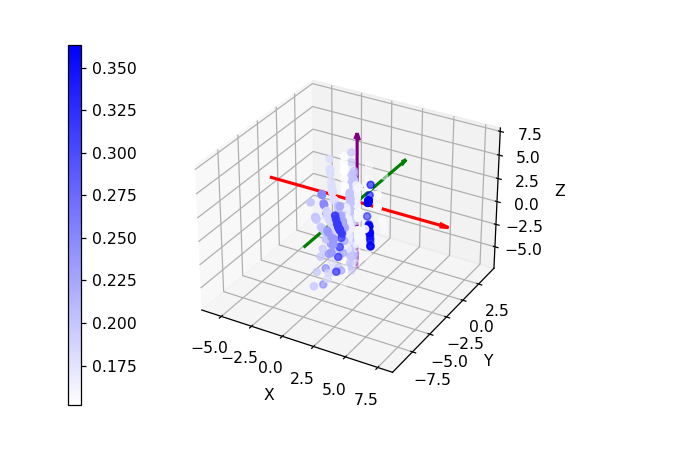

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# 自定义颜色映射
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'white'), (1, 'blue')])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
sc = ax.scatter(x_cor_add, y_cor_add, z_cor_add, c=color_add, marker='o', cmap=custom_cmap)

# 添加颜色条
cax = fig.add_axes([0.1, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cax, pad=0.1)

# 动态计算数据范围
x_range = np.ptp(x_cor_add)  # x轴范围
y_range = np.ptp(y_cor_add)  # y轴范围
z_range = np.ptp(z_cor_add)  # z轴范围
max_range = max(x_range, y_range, z_range)

# 数据中心
x_center = np.mean(x_cor_add)
y_center = np.mean(y_cor_add)
z_center = np.mean(z_cor_add)

# 动态调整箭头大小
arrow_scale = max_range * 0.5

# 添加自适应箭头
ax.quiver(0, 0, 0, arrow_scale, 0, 0, color='red', label='X+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, -arrow_scale, 0, 0, color='red', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, arrow_scale, 0, color='green', label='Y+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, -arrow_scale, 0, color='green', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, 0, arrow_scale, color='purple', label='Z+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, -arrow_scale, color='purple', linewidth=2, arrow_length_ratio=0.0)

# 设置坐标轴范围以居中散点
ax.set_xlim(x_center - max_range / 2, x_center + max_range / 2)
ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)
ax.set_zlim(z_center - max_range / 2, z_center + max_range / 2)

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

# plt.savefig("/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D/add_importance_plot_all.png", dpi=900, bbox_inches='tight')


In [116]:
# x_cor_cat, y_cor_cat, z_cor_cat
x_tmp = np.array(x_cor_add)
y_tmp = np.array(y_cor_add)
z_tmp = np.array(z_cor_add)
color_tmp = np.array(color_add)
# # 1. 根据 x 坐标的正负进行分组
# positive_x_indices = x_tmp > 0
# negative_x_indices = x_tmp < 0

# # 2. 获取 x 正半部分和负半部分的点
# positive_x_points = (x_tmp[positive_x_indices], y_tmp[positive_x_indices], z_tmp[positive_x_indices])
# negative_x_points = (x_tmp[negative_x_indices], y_tmp[negative_x_indices], z_tmp[negative_x_indices])

# # 3. 找到正半部分 x 值最小的点
# min_positive_x_index = np.argmin(positive_x_points[0])
# min_positive_x_point = (positive_x_points[0][min_positive_x_index], 
#                         positive_x_points[1][min_positive_x_index], 
#                         positive_x_points[2][min_positive_x_index])

# # 4. 找到负半部分 x 值最大的点
# max_negative_x_index = np.argmax(negative_x_points[0])
# max_negative_x_point = (negative_x_points[0][max_negative_x_index], 
#                         negative_x_points[1][max_negative_x_index], 
#                         negative_x_points[2][max_negative_x_index])

# # 输出结果
# print("The point with the smallest x in the positive x half:", min_positive_x_point)
# print("The point with the largest x in the negative x half:", max_negative_x_point)

# z_tmp = z_tmp[x_tmp>0]
# print(z_tmp.shape)
print(z_tmp[color_tmp>0.3].max()-z_tmp[color_tmp>0.3].min())
print(x_tmp[color_tmp>0.3].max() - x_tmp[color_tmp>0.3].min())
print(color_tmp.max())

6.997949614964234
0.6412422806103908
0.3632130414662263


In [101]:
# 根据所有的分子结构将特征重要性回溯到三维表面
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_add,
    y=y_cor_add,
    z=z_cor_add,
    mode='markers',
    marker=dict(
        size=4,
        color=color_add,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend'),
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
         showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of CPA',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
os.makedirs('/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D', exist_ok=True)
fig.write_html("/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D/add_importance_plot_all.html")

In [160]:
# 根据每个分子结构分别将特征重要性回溯到三维表面
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/add_grad"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in add_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_add_importance_dict[tmp_key]
    # cat
    importances_add_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_add_neg = importances[:, num_bins:]

    add_matric = new_add_desc_dict[tmp_key]

    x_cor_add, y_cor_add, z_cor_add, color_add = [], [], [], []

    print(tmp_key)

    add_z_pos = add_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    add_z_neg = add_matric[::-1, num_bins:]

    for y_index in range(importances_add_pos.shape[0]):
        y_project = y_min_mid_add + y_index * y_step_add
        for x_index in range(importances_add_pos.shape[1]):
            x_project = x_min_mid_add + x_index * x_step_add
            z_project = add_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_add_pos[y_index, x_index]

            x_cor_add.append(x_cor)
            y_cor_add.append(y_cor)
            z_cor_add.append(z_cor)
            color_add.append(importance_color)

    #             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    for y_index in range(importances_add_neg.shape[0]):
        y_project = y_min_mid_add + y_index * y_step_add
        for x_index in range(importances_add_neg.shape[1]):
            x_project = x_min_mid_add + x_index * x_step_add
            z_project = add_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_add_pos[y_index, x_index]

            x_cor_add.append(x_cor)
            y_cor_add.append(y_cor)
            z_cor_add.append(-z_cor)
            color_add.append(importance_color)

    #             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go

    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_cat 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_add,
        y=y_cor_add,
        z=z_cor_add,
        mode='markers',
        marker=dict(
            size=4,
            color=color_add,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )


    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
            showlegend=False  # 不显示箭头的图例
        )
        return arrow


    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')

    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of CPA',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
    #     fig.show()

    # Save the plot as an HTML file
    fig.write_html("{}/{}.html".format(path, index))

    index = index + 1

FC(C=CC=C1F)=C1C2=CC=NO2
C1(C2=CC=CC=C2)=CON=C1
O=C(OC)C1=NOC(C2=CC=CS2)=C1
CC1=C(C(OCC)=O)C=NO1
C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1
C12=C(C=CC=C2)ON=C1
CC1=NOC(C(OCC)=O)=C1
CC1=NOC=C1
C12=CON=C1C=CC=C2
O=C(OC)C1=NOC(C2=CC=CO2)=C1
O=C(OC)C1=CC=NO1
C1(C2=CC=CC=C2)=NOC=C1
COC1=NOC(C(OCC)=O)=C1
CCOC(C1=CON=C1)=O
CC1=NOC(C2=CC=CC=C2)=C1
CC1=CC=NO1
CC1=CC(C(OCC)=O)=NO1
C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1
CC1=CC(C)=NO1
CC1=CC(N2C=CC=C2)=NO1
CCOC(C1=NOC=C1)=O
C1(C2=CC=CC=C2)=CC=NO1


### Base

In [102]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Doyle/Jishe_81/base_projected_points.npy', allow_pickle=True)
origin_cat = projected_points_list[0]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']

# 确定每个数据点所在的象限
samples = origin_cat
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Cat',
    title_x=0.5  # 设置标题在X轴中央

)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()

color_origin = []

# Save the plot as an HTML file
# fig.write_html("cat_point_plot.html")

In [161]:
import math
import sympy as sp
from scipy.optimize import newton

# _, height, width, channel = react_spms_std.shape
importances = feature_importances.reshape(height, width, channel)

# cat
importances_base_pos = importances[:, :num_bins, 2]  # 为了从上往下y坐标依次增大
importances_base_neg = importances[:, num_bins:, 2]
x_cor_base, y_cor_base, z_cor_base, color_base = [], [], [], []

for base_matric in new_base_desc_dict.values():
    # for cat_matric in [cat_matric]:

    base_z_pos = base_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    base_z_neg = base_matric[::-1, num_bins:]

    for y_index in range(importances_base_pos.shape[0]):
        y_project = y_min_mid_base + y_index * y_step_base
        for x_index in range(importances_base_pos.shape[1]):
            x_project = x_min_mid_base + x_index * x_step_base
            z_project = base_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_base_pos[y_index, x_index]

#             if (importance_color <= 0.5):
#                 continue

            x_cor_base.append(x_cor)
            y_cor_base.append(y_cor)
            z_cor_base.append(z_cor)
            color_base.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)

print('+++++++++++++++++++++++++++++++++++')
for base_matric in new_base_desc_dict.values():
    # for cat_matric in [cat_matric]:

    base_z_pos = base_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    base_z_neg = base_matric[::-1, num_bins:]

    for y_index in range(importances_base_neg.shape[0]):
        y_project = y_min_mid_base + y_index * y_step_base
        for x_index in range(importances_base_neg.shape[1]):
            x_project = x_min_mid_base + x_index * x_step_base
            z_project = base_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_base_pos[y_index, x_index]

#             if (importance_color <= 0.5):
#                 continue

            x_cor_base.append(x_cor)
            y_cor_base.append(y_cor)
            z_cor_base.append(-z_cor)
            color_base.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)



theta/2:  0.7761734564675575
coordinate -0.6199517714972899 -5.942753942394665 0.11024781801238276 0.004959953
theta/2:  0.7761508049827767
coordinate 0.45439536169959105 -5.943018244914986 0.11024781801238276 0.0067137643
theta/2:  0.7762484949708365
coordinate 0.9913925290011387 -5.941878375013097 0.11024781801238276 0.008253606
theta/2:  0.7753620770150073
coordinate -0.6209393969653563 -5.456616072115786 0.11024781801238276 0.0075971596
theta/2:  0.738742712611623
coordinate -0.08886278216369183 -5.847671691755328 0.5473038840260197 0.009979278
theta/2:  0.7388858177259726
coordinate 0.48758713980187324 -5.8461473210377894 0.5473038840260197 0.00998385
theta/2:  0.7394299948863149
coordinate 1.0629588275338 -5.840350318120492 0.5473038840260197 0.018240336
theta/2:  0.7675096283738826
coordinate 1.5547011942420905 -5.540591912436952 0.20597009734333419 0.014095857
theta/2:  0.7563437000488907
coordinate -0.6440741173173297 -5.1458464217148245 0.3016923766742856 0.0131570315
theta/2

theta/2:  0.7785772864265748
coordinate 5.798511240341028 -4.929741796757314 0.10383182798547794 0.034311302
theta/2:  0.7789253288118444
coordinate 6.328790622033682 -4.926356758277782 0.10383182798547794 0.03299271
theta/2:  0.7256601208977028
coordinate 3.450816493110501 -4.899313498180236 0.7194002031590646 0.036893263
theta/2:  0.7278403924672675
coordinate 4.025478909241837 -4.880356201588463 0.7314920510876809 0.05193012
theta/2:  0.7154824910391052
coordinate 5.315884523659899 -4.987670145775289 1.0259835300238802 0.053257555
theta/2:  0.7474714045467138
coordinate 6.153978592521723 -4.709278819503712 0.5889274640102433 0.06833249
theta/2:  0.779805911450684
coordinate -0.08219782029497019 -3.9352170973506575 0.04402488714242603 0.021517755
theta/2:  0.7798407037731865
coordinate 0.4511032737707924 -3.9349463122207045 0.04402488714242603 0.034247443
theta/2:  0.7799701375160213
coordinate 0.9841466993426224 -3.9339389406523773 0.04402488714242603 0.027852863
theta/2:  0.7842176

theta/2:  0.34030124407128953
coordinate 1.7302361860171895 -1.735553673049619 3.0268154931229465 0.059716962
theta/2:  0.4712418136935799
coordinate 2.383275855237584 -1.5505784659645616 2.065745690282201 0.063572474
theta/2:  0.5597290799324882
coordinate 2.913190693966065 -1.4025202922070892 1.567165287886882 0.067941226
theta/2:  0.5736120011627059
coordinate 3.606393123832294 -1.3779591733476544 1.7406417988597587 0.08790335
theta/2:  0.5967743995999557
coordinate 4.219087726927423 -1.336301880493486 1.7535527548907244 0.0764108
theta/2:  0.6127625022829799
coordinate 4.832806996908664 -1.307091756596282 1.8007135506556124 0.09941428
theta/2:  0.6573902581730195
coordinate 5.186080013476153 -1.2238648104867977 1.3947964142819682 0.10607032
theta/2:  0.7079926547691859
coordinate 5.385016135146948 -1.1271503590111276 0.8585962310372018 0.105883785
theta/2:  0.6837444735282566
coordinate 6.241568884356203 -1.1737486659213026 1.3092890826555013 0.17912737
theta/2:  0.6914648945367452

theta/2:  0.7177924468599319
coordinate 0.5062847148101449 -4.416290652965064 0.6047338309564967 0.034247443
theta/2:  0.742402657989475
coordinate 1.0571934895283062 -4.225929568262136 0.3755167259497858 0.027852863
theta/2:  0.7439239063293036
coordinate 1.6253747726643746 -4.214131331305427 0.3755167259497858 0.039585497
theta/2:  0.7314221720712472
coordinate -2.42708736654106 -3.772791013848 0.4861687323645388 0.0040277336
theta/2:  0.6485829706964076
coordinate -2.1131372085998072 -4.326192304360925 1.3513430634010217 0.010832003
theta/2:  0.5932466167064276
coordinate -1.56211449363152 -4.682731145549836 1.9963392517381646 0.018206397
theta/2:  0.5899184634150745
coordinate -0.8406908891299494 -4.703719430393534 1.969486886290132 0.021630758
theta/2:  0.5756327757743155
coordinate -0.11440013778288738 -4.793144355118165 2.138398473389614 0.027799267
theta/2:  0.631611646828082
coordinate 0.5812131875900302 -4.4369430889302235 1.4214517815295875 0.039780006
theta/2:  0.6909618803

theta/2:  0.4305222242061796
coordinate 0.736872619472191 3.20180057886953 2.8225639968676726 0.03299362
theta/2:  0.4711192123071901
coordinate 1.5460208317296804 3.078379392510705 2.5040488232511553 0.036320753
theta/2:  0.550187040991619
coordinate 2.1813631296899203 2.8172250830816328 1.8117850603529093 0.040146936
theta/2:  0.6319516952851406
coordinate 2.641233374680675 2.5241848691156314 1.1577934460111954 0.05514967
theta/2:  0.7004830841149876
coordinate -2.561336770322098 2.8341662065930584 0.6550733816692145 0.005239723
theta/2:  0.6044487542773402
coordinate -2.2525827724319583 3.2827678641714924 1.5072070346180022 0.008661763
theta/2:  0.5643410698019861
coordinate -1.6222604644761467 3.4616905150251553 1.8096592166056196 0.0145497685
theta/2:  0.5672119231432803
coordinate -0.8660009760858394 3.449091702914378 1.6584331256118108 0.018100325
theta/2:  0.6170630688650651
coordinate -0.10814205587805673 3.2252982043160547 1.1294719579547852 0.037727825
theta/2:  0.6107596093

theta/2:  0.4164969816273308
coordinate -1.9004049324826873 -0.008133436388934604 -1.727612600726144 0.018689377
theta/2:  0.1626349714835738
coordinate -1.1855250582064507 -0.009470161154207311 -3.5153998454835516 0.028922306
theta/2:  0.1626349714835738
coordinate -1.3889350458080467 -0.08308401223355288 -4.125795449949356 0.038208798
theta/2:  0.11172859819289407
coordinate 0.8811966097776536 -0.009604235033787772 -3.87784356064038 0.044057608
theta/2:  0.3493287922334802
coordinate 1.7190522788101534 -0.008585863674395247 -2.0465256423594282 0.055957884
theta/2:  0.47016462803474535
coordinate 2.3858899632589714 -0.0077291563217818165 -1.7413040258049715 0.07609884
theta/2:  0.6612714887042781
coordinate -2.729379955544766 0.5991759332506288 -0.7083241489807988 0.0038897858
theta/2:  0.5884818942656508
coordinate -2.30195751909559 0.6655618984581264 -0.9957399283351881 0.0117309475
theta/2:  0.38169105823762545
coordinate -1.9570291469260062 0.8285079493672185 -2.2208781142649467 0

theta/2:  0.6758068602842884
coordinate 3.753720336245539 -2.9633880982732093 -1.0653508217417527 0.06581224
theta/2:  0.6463032830250064
coordinate 4.602309607335029 -3.1025804437031996 -1.5851770249134665 0.09156932
theta/2:  0.6507630036137543
coordinate 5.239048180437156 -3.08167774798946 -1.6774139679907063 0.08941178
theta/2:  0.6522818464949351
coordinate 5.893125765519906 -3.0745470928271965 -1.8126623416574794 0.0823973
theta/2:  0.6529086326626509
coordinate 6.553044339987838 -3.071602734304053 -1.963888432651288 0.09321045
theta/2:  0.6612289868108245
coordinate 7.126532962429133 -3.0324243506047543 -1.963888432651288 0.07684148
theta/2:  0.683745086102148
coordinate 7.509415491312126 -2.9256021960273983 -1.6614362506636708 0.081567146
theta/2:  0.738581473267623
coordinate 7.408814354435938 -2.6617135549261524 -0.7392845486252684 0.088314496
theta/2:  0.7772452028884136
coordinate 7.421849084469217 -2.4738195489800874 -0.1275770063765302 0.081752345
theta/2:  0.686198012137

theta/2:  0.6795694626429133
coordinate 5.645764121195232 0.5820379203803344 -1.2195674865932822 0.12262017
theta/2:  0.6643365016345794
coordinate -1.4085647323048869 1.1986597065644014 -0.45678062575247785 0.014930835
theta/2:  0.4524989539651534
coordinate -0.9847215560889936 1.5640522135423685 -1.4516662864861656 0.02431413
theta/2:  0.30719865911517674
coordinate -0.1477113434799725 1.7568737088369073 -2.499094508800221 0.03006295
theta/2:  0.32320494442112646
coordinate 0.8022799775069407 1.7386296687842173 -2.5376643471755727 0.037961587
theta/2:  0.4337933918475983
coordinate 1.6031603675529402 1.5920732406332658 -1.9154835726234207 0.04307492
theta/2:  0.45884093379507457
coordinate 2.4131194075508757 1.5543601877403754 -2.1962283097961737 0.05029685
theta/2:  0.4537215618838988
coordinate 3.2774836516086228 1.5621912109112492 -2.837401239383614 0.067869656
theta/2:  0.47909672582715096
coordinate 4.025503993513156 1.522779292013369 -3.0247808133036465 0.07267205
theta/2:  0.5

theta/2:  0.24021325642873934
coordinate -1.3065280838280977 -0.07815455130740225 -2.5114761796500944 0.038208798
theta/2:  0.17470602140032895
coordinate 0.8653303739714254 -0.009431307612036838 -2.375058229720172 0.044057608
theta/2:  0.38565664782590164
coordinate 1.671628835718968 -0.008349005713546503 -1.7194155493231762 0.055957884
theta/2:  0.7206824067404135
coordinate 1.6947470010135441 -0.005490179638801226 -0.22058799932359177 0.07609884
theta/2:  0.7014444944191494
coordinate -2.5571837567557805 0.5613740076147353 -0.4437726840885026 0.0038897858
theta/2:  0.6285494505920427
coordinate -2.1769344767022214 0.6294141534384731 -0.7351433947642606 0.0117309475
theta/2:  0.5711831834445049
coordinate -1.608162882974554 0.6808154771299877 -0.7975913411933319 0.016827716
theta/2:  0.35253533288589894
coordinate -1.0723035611834781 0.84729733455469 -1.6059527698179976 0.03025349
theta/2:  0.2996218081273757
coordinate -0.14841379495302834 0.8781753760542023 -1.3039429758883307 0.03

In [162]:
# 根据所有的分子结构将特征重要性回溯到三维表面
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_base,
    y=y_cor_base,
    z=z_cor_base,
    mode='markers',
    marker=dict(
        size=4,
        color=color_base,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend'),
    ),
    showlegend=False  # 不显示箭头的图例
)


def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
        showlegend=False  # 不显示箭头的图例
    )
    return arrow


# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of CPA',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
os.makedirs(
    '/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v',
    exist_ok=True)
fig.write_html(
    "/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/base_importance_plot_all.html")



In [163]:
# 根据每个分子结构分别将特征重要性回溯到三维表面
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/base_grad"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in base_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_base_importance_dict[tmp_key]
    # cat
    importances_base_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_base_neg = importances[:, num_bins:]

    base_matric = new_base_desc_dict[tmp_key]

    x_cor_base, y_cor_base, z_cor_base, color_base = [], [], [], []

    print(tmp_key)

    base_z_pos = base_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    base_z_neg = base_matric[::-1, num_bins:]

    for y_index in range(importances_base_pos.shape[0]):
        y_project = y_min_mid_base + y_index * y_step_base
        for x_index in range(importances_base_pos.shape[1]):
            x_project = x_min_mid_base + x_index * x_step_base
            z_project = base_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_base_pos[y_index, x_index]

            x_cor_base.append(x_cor)
            y_cor_base.append(y_cor)
            z_cor_base.append(z_cor)
            color_base.append(importance_color)

    #             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    for y_index in range(importances_base_neg.shape[0]):
        y_project = y_min_mid_base + y_index * y_step_base
        for x_index in range(importances_base_neg.shape[1]):
            x_project = x_min_mid_base + x_index * x_step_base
            z_project = base_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_base_pos[y_index, x_index]

            x_cor_base.append(x_cor)
            y_cor_base.append(y_cor)
            z_cor_base.append(-z_cor)
            color_base.append(importance_color)

    #             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go

    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_cat 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_base,
        y=y_cor_base,
        z=z_cor_base,
        mode='markers',
        marker=dict(
            size=4,
            color=color_base,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )


    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
            showlegend=False  # 不显示箭头的图例
        )
        return arrow


    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')

    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of CPA',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
    #     fig.show()

    # Save the plot as an HTML file
    fig.write_html("{}/{}.html".format(path, index))

    index = index + 1

CN1CCCN2C1=NCCC2
CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC
CC(C)(C)/N=C(N(C)C)/N(C)C


### Ar

In [106]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Doyle/Jishe_81/ar_projected_points.npy', allow_pickle=True)
origin_cat = projected_points_list[0]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']

# 确定每个数据点所在的象限
samples = origin_cat
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Cat',
    title_x=0.5  # 设置标题在X轴中央

)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()

color_origin = []

# Save the plot as an HTML file
# fig.write_html("cat_point_plot.html")


In [164]:
import math
import sympy as sp
from scipy.optimize import newton

# _, height, width, channel = react_spms_std.shape
importances = feature_importances.reshape(height, width, channel)

# cat
importances_ar_pos = importances[:, :num_bins, 3]  # 为了从上往下y坐标依次增大
importances_ar_neg = importances[:, num_bins:, 3]
x_cor_ar, y_cor_ar, z_cor_ar, color_ar = [], [], [], []

for ar_matric in new_ar_desc_dict.values():
    # for cat_matric in [cat_matric]:

    ar_z_pos = ar_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    ar_z_neg = ar_matric[::-1, num_bins:]

    for y_index in range(importances_ar_pos.shape[0]):
        y_project = y_min_mid_ar + y_index * y_step_ar
        for x_index in range(importances_ar_pos.shape[1]):
            x_project = x_min_mid_ar + x_index * x_step_ar
            z_project = ar_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_ar_pos[y_index, x_index]

            if (importance_color <= 0.01):
                continue

            x_cor_ar.append(x_cor)
            y_cor_ar.append(y_cor)
            z_cor_ar.append(z_cor)
            color_ar.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)

print('+++++++++++++++++++++++++++++++++++')
for ar_matric in new_ar_desc_dict.values():
    # for cat_matric in [cat_matric]:

    ar_z_pos = ar_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    ar_z_neg = ar_matric[::-1, num_bins:]

    for y_index in range(importances_ar_neg.shape[0]):
        y_project = y_min_mid_ar + y_index * y_step_ar
        for x_index in range(importances_ar_neg.shape[1]):
            x_project = x_min_mid_ar + x_index * x_step_ar
            z_project = ar_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_ar_pos[y_index, x_index]

            if (importance_color <= 0.01):
                continue

            x_cor_ar.append(x_cor)
            y_cor_ar.append(y_cor)
            z_cor_ar.append(-z_cor)
            color_ar.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)



theta/2:  0.6949200326270926
coordinate -0.8523595127620518 -2.075521201501723 0.41050672984707615 0.030569175
theta/2:  0.6870446857593124
coordinate -0.4345297005081183 -2.1027332938334125 0.42789486430276424 0.03870351
theta/2:  0.6887365296068202
coordinate -0.0055092888341461855 -2.0968943408840324 0.41050672984707615 0.04429199
theta/2:  0.72850583822768
coordinate 0.19466049330527702 -1.9586716562846846 0.22493629611594224 0.06991856
theta/2:  0.6922731200276049
coordinate 0.6325043704835139 -2.0846763127381913 0.41050672984707615 0.044174884
theta/2:  0.6869709868878668
coordinate -1.0781676631509163 -1.753356567769906 0.41050672984707615 0.040736992
theta/2:  0.6051223654178095
coordinate -0.9771972880120207 -1.9839017295509263 0.8338120006764083 0.040613994
theta/2:  0.4954897068889215
coordinate -0.0071533552442844895 -2.269992072901798 1.486640634738258 0.05147696
theta/2:  0.4967829141826446
coordinate 0.2702084713290013 -2.2668162696106138 1.486640634738258 0.068764664
th

theta/2:  0.19849927786515362
coordinate -1.0436203613692705 1.115889018572015 3.644181528017131 0.09974884
theta/2:  0.15930186504153263
coordinate -0.7086851096489712 1.131823141138309 4.048583651495195 0.10957949
theta/2:  0.13226822595581195
coordinate -0.36170791731011304 1.1408444640026272 4.418156066013637 0.16002281
theta/2:  0.1265333832032359
coordinate -0.009095636475955479 1.142548480580866 4.418156066013637 0.12822276
theta/2:  0.1317207978915947
coordinate 0.34359371634796426 1.1410103093987076 4.418156066013637 0.2097062
theta/2:  0.15829350494458105
coordinate 0.690887701812684 1.1321887449199592 4.048583651495195 0.3321937
theta/2:  0.1971816132759023
coordinate 1.026395637981226 1.116478682124215 3.644181528017131 0.15508685
theta/2:  0.25751757199382935
coordinate 1.3337194247935913 1.0857308985639833 3.0385326112068523 0.13539974
theta/2:  0.37201428506106693
coordinate 1.549236327766712 1.0076340752043236 2.0077000000000007 0.148032
theta/2:  0.7675458635936159
coo

coordinate 0.7494794720376788 3.6900484086583067 1.6647478180123827 0.13691528
theta/2:  0.6260625896076323
coordinate 0.9365359937922868 3.4507927602535555 1.1796521819876173 0.082810946
theta/2:  0.7744160187665909
coordinate 0.9121503509080955 2.685272022378067 0.062300000000000105 0.1563422
theta/2:  0.7749162730667297
coordinate 1.2776478935388282 2.682643727573029 0.062300000000000105 0.09377825
theta/2:  0.6379109377124823
coordinate -0.9323569844673297 3.7688877694663954 1.1796521819876173 0.023401825
theta/2:  0.7197485333679582
coordinate -0.614003649149229 3.3022921393917533 0.4435715293189501 0.030194435
theta/2:  0.5907948259902942
coordinate -0.5014166663062417 4.02800596570218 1.6647478180123827 0.041361474
theta/2:  0.7416496718252635
coordinate -0.20013898820164963 3.1751642984887205 0.27908120298461625 0.047081623
theta/2:  0.5897003978168907
coordinate -0.006384388553282093 4.033916750435887 1.6647478180123827 0.07100618
theta/2:  0.589955287776571
coordinate 0.24141

theta/2:  0.2885691979449454
coordinate -1.6575158457276977 -0.007996687256253469 2.5458000000000003 0.048796862
theta/2:  0.2025228028222451
coordinate -1.386263588435568 -0.008349341014759093 3.2333000000000003 0.082050346
theta/2:  0.144172645710453
coordinate -1.0634316566366546 -0.008521764525609552 3.5853815280171313 0.073073216
theta/2:  0.09181374862481655
coordinate -0.7208671116332646 -0.008628234870726092 3.881758360831664 0.08683811
theta/2:  0.09181374862481655
coordinate -0.5764432533240005 -0.5426747166900666 4.262856066013637 0.13081916
theta/2:  0.09181374862481655
coordinate 0.8483089040722308 -0.021112509900279557 4.5691 0.1798771
theta/2:  0.08509121756502933
coordinate 0.7033750187775412 -0.008638529011029582 4.093395457622364 0.12352492
theta/2:  0.14193560016483897
coordinate 1.046001442555373 -0.008527258057166198 3.5853815280171317 0.285588
theta/2:  0.2003598101537292
coordinate 1.3697353216590473 -0.008356720199962774 3.2333000000000003 0.14807032
theta/2:  0

theta/2:  0.3975898960008774
coordinate 0.9073396138119378 2.9757143262634527 3.050697977995455 0.11350788
theta/2:  0.37260785372738
coordinate 1.237211029686349 3.0365975006211237 3.5536653719913267 0.13626425
theta/2:  0.3963259953447445
coordinate 1.5190796696587028 2.97886931673244 3.295677170669524 0.121536635
theta/2:  0.6050390471075491
coordinate 1.6930979003569637 2.3680067140996583 1.0981038116628574 0.12232234
theta/2:  0.7698660394276959
coordinate 1.660297271556989 1.8046209005470435 0.07620000000000011 0.099276446
theta/2:  0.4603111250308741
theta/2:  0.6059088796472286
theta/2:  0.4379186039812975
coordinate -2.3622608658115816 3.350741577072628 3.417971966993182 0.018906277
theta/2:  0.48533057636702753
coordinate -1.9726200788876422 3.1963138844085033 2.5703738728246104 0.023952212
theta/2:  0.38852577413045375
coordinate -1.8521201578836257 3.4991024322047037 4.025695875999372 0.0355006
theta/2:  0.3945590615905956
coordinate -1.5370763346156007 3.481713907770428 3.

theta/2:  0.27151498320016865
coordinate -0.6746891459161508 -1.6364823641651187 2.9327980941685716 0.06933383
theta/2:  0.233434059649038
coordinate -0.3484133295221305 -1.6689584726165314 3.3825981303501527 0.0773618
theta/2:  0.23268345852869357
coordinate -0.008751377171557622 -1.6695533012590347 3.3248490651750764 0.08245693
theta/2:  0.22718020087720645
coordinate 0.33188870247743896 -1.6738601468665406 3.493634628008673 0.1165645
theta/2:  0.24103021394248947
coordinate 0.6681231568988258 -1.6628391468095434 3.4249480262375624 0.11651717
theta/2:  0.31157646514545806
coordinate 0.9670509667084447 -1.5975974010207112 2.5984961883371427 0.09691863
theta/2:  0.3681740957922227
coordinate 1.241478558535628 -1.534897182309354 2.17795 0.09387494
theta/2:  0.4558060107914627
coordinate 1.4392084838982695 -1.421645217674848 1.5673923766742857 0.098676205
theta/2:  0.5033802215302006
coordinate 1.6450643162336387 -1.3529898398931959 1.3473961883371428 0.124154836
theta/2:  0.661473403159

theta/2:  0.3313806078085804
coordinate 2.558782382895688 1.5611008063137093 3.840166899132965 0.11231846
theta/2:  0.7594693353492227
coordinate 1.6937511673423458 0.9182033085428507 0.10000000000000012 0.13606587
theta/2:  0.761499507211308
theta/2:  0.6290070800402029
coordinate -1.6485716212293542 1.5239876314718037 0.7260500000000003 0.02469761
theta/2:  0.5000178044590783
coordinate -1.665380063160846 1.7950167676282305 1.572096188337143 0.037206024
theta/2:  0.3248239534342562
coordinate -1.6198835661876998 2.09338494524683 3.484423146747179 0.054505628
theta/2:  0.23666858847334166
coordinate -1.3652917935687596 2.2026461663052967 5.059754981731173 0.080795266
theta/2:  0.20568055417262515
coordinate -1.0405538035384179 2.233558649105796 5.648244320869936 0.087053046
theta/2:  0.19698554133411658
coordinate -0.6991319982809322 2.2415002970947295 5.648244320869936 0.1250451
theta/2:  0.19139537779087942
coordinate -0.3547896610044052 2.2464343926153045 5.648244320869936 0.098860

theta/2:  0.5540500402942592
coordinate 0.7718948430898683 -2.5440945081282305 1.3261478180123827 0.044174884
theta/2:  0.6574086351410229
coordinate 0.8936691439563403 -2.2043164808768814 0.6225241489807988 0.048005477
theta/2:  0.6380933906619334
coordinate -1.3951754845919855 -1.8923550791171042 0.713407623325715 0.024757557
theta/2:  0.5894881860922225
coordinate -0.9982038994039024 -2.026549261613915 0.9334038116628575 0.040613994
theta/2:  0.4690256521156765
coordinate -0.5784422011108687 -2.3337709867716154 1.7632038840260196 0.04983798
theta/2:  0.43357142194577936
coordinate -0.30314041685477455 -2.4153789257186524 2.065656066013637 0.061639726
theta/2:  0.43200202095227597
coordinate -0.007622553917436717 -2.418884058871961 2.065656066013637 0.05147696
theta/2:  0.4334188479014909
coordinate 0.2879580686562732 -2.4157200985786833 2.065656066013637 0.068764664
theta/2:  0.4687461619287845
coordinate 0.5638931709841085 -2.3344319108557214 1.7632038840260196 0.08717408
theta/2: 

theta/2:  0.1968216596498011
coordinate 1.0265431278185457 1.679142989491524 4.738688315596834 0.2201563
theta/2:  0.22745278835979812
coordinate 1.3537059452203084 1.6571312241264078 4.374730819762868 0.1484088
theta/2:  0.3383202833708478
coordinate 1.5884500184049235 1.5535798175677071 2.7665692077752384 0.1466507
theta/2:  0.4524375315051394
coordinate 1.7342344704107877 1.41225124482783 1.7570923766742856 0.24426655
theta/2:  0.6535344804375182
coordinate 1.5776354472827792 1.1005166843720744 0.5193923766742856 0.13504088
theta/2:  0.7646013657302384
coordinate 1.6772412358279847 0.9092530719127034 0.07940000000000011 0.13606587
theta/2:  0.7662441487393665
theta/2:  0.6655113722771588
coordinate -1.5600427642998624 1.442148977177686 0.5193923766742856 0.02469761
theta/2:  0.5041011430957779
coordinate -1.6579302980240558 1.7869870970255635 1.5370961883371428 0.037206024
theta/2:  0.3556869927783603
coordinate -1.5848658827357436 2.0481313894445052 3.0045907229123037 0.054505628
t

coordinate -0.42133743005334856 -2.716845048462383 0.44319611597398045 0.02391182
theta/2:  0.6721091580192546
coordinate -0.005659591204038661 -2.870358694516772 0.6617241489807989 0.027398648
theta/2:  0.7048513217997749
coordinate 0.2028519484771946 -2.719775802339347 0.44319611597398045 0.019140366
theta/2:  0.697442592115076
coordinate -0.6379372993542347 -2.410400584589708 0.44319611597398045 0.029794168
theta/2:  0.6409717179773093
coordinate -0.4670299756720248 -2.63574132604063 0.7954479779954543 0.041237004
theta/2:  0.753332794531339
coordinate -0.1958507593058243 -2.182862863696752 0.1407439339863632 0.02728588
theta/2:  0.645377949964261
coordinate -0.0058987503357069305 -2.618389953848101 0.753045875999373 0.026763128
theta/2:  0.6457776260018664
coordinate 0.2229952991908649 -2.6168138647271264 0.753045875999373 0.027003102
theta/2:  0.7536535660343339
coordinate 0.376721952892883 -2.1815494836706857 0.1407439339863632 0.03288064
theta/2:  0.6624141431047728
coordinate 0

theta/2:  0.1579073900053564
coordinate -1.0589948362957076 0.5619209676957125 3.668981528017131 0.111640275
theta/2:  0.11418710340058363
coordinate -0.7175404451829468 0.5686886786607618 3.9391431864335456 0.11348808
theta/2:  0.08383317905309336
coordinate -0.36552947286571663 0.5721287338832878 4.01126341896437 0.099669114
theta/2:  0.06857607967320649
coordinate -0.009199434596729558 0.5734632794158318 4.15550388402602 0.16383639
theta/2:  0.0826725326401857
coordinate 0.34724067563735067 0.5722395670997933 4.01126341896437 0.18071519
theta/2:  0.11060250368979882
coordinate 0.6998608558955381 0.5691490431728933 4.01126341896437 0.30585262
theta/2:  0.19461469411551885
coordinate 1.0274418377410846 0.5546203737089808 2.846681528017131 0.16334328
theta/2:  0.24768286678925702
coordinate 1.3405079154636503 0.5415393746743871 2.6758480941685714 0.323628
theta/2:  0.3405957935119038
coordinate 1.585899286584225 0.5118747565853049 2.05575 0.13528806
theta/2:  0.7853981633974361
coordin

theta/2:  0.5330871547664604
coordinate -0.5392275505909984 3.8979298480872373 2.17340388402602 0.04975125
theta/2:  0.5314793734766516
coordinate -0.006868759576861879 3.9053192460268686 2.17340388402602 0.06489619
theta/2:  0.531854325702286
coordinate 0.2597071767834466 3.903597135887483 2.17340388402602 0.08994366
theta/2:  0.5709167475361441
coordinate 0.7556524815758485 3.7204411076885084 1.7363478180123828 0.13691528
theta/2:  0.6591805164812523
coordinate 0.8912232524274076 3.2838318736612493 0.8776639803218282 0.082810946
theta/2:  0.7690971701109364
coordinate -0.7459028428418162 3.0151799669338377 0.10130000000000011 0.023401825
theta/2:  0.7125473861744382
coordinate -0.6217480410250327 3.3439437557156495 0.4991048626522834 0.030194435
theta/2:  0.6057523973171917
coordinate -0.49129587627874793 3.946703118493935 1.4938000000000002 0.041361474
theta/2:  0.7331819000912585
coordinate -0.20324168487392197 3.224387949469273 0.33863120298461624 0.047081623
theta/2:  0.640041919

theta/2:  0.7853981633974361
coordinate 0.004180764769419435 -0.0007705421886062305 1.0409497792752501e-16 0.11505915
theta/2:  0.4900727236183934
coordinate -1.6833601825987659 -0.00677359653064072 1.1287 0.049886677
theta/2:  0.35776745905105645
coordinate -1.582410199954145 -0.007634339974942033 1.82056 0.048796862
theta/2:  0.2029720412748587
coordinate -1.3860075668993495 -0.008347799020054157 3.2247 0.082050346
theta/2:  0.14448781980326697
coordinate -1.063334234447353 -0.00852098383702311 3.576781528017131 0.073073216
theta/2:  0.09261250054842211
coordinate -0.7207606259483377 -0.00862696031750388 3.8469431864335455 0.08683811
theta/2:  0.09261250054842211
coordinate -0.6018303511122676 -0.5665746166722203 4.411330819762868 0.13081916
theta/2:  0.09034614785427245
coordinate 0.7027252000563005 -0.008630548235873387 3.8469431864335455 0.12352492
theta/2:  0.14224677575963862
coordinate 1.0459083205623623 -0.008526498904039928 3.576781528017131 0.285588
theta/2:  0.2008059285881

theta/2:  0.7642706846590376
coordinate 1.4912917340405218 2.1289824058519096 0.10990000000000011 0.11897988
theta/2:  0.4554413774828897
coordinate -2.033502989007304 3.7666766766354662 3.321552181987617 0.017821206
theta/2:  0.5393129019781948
coordinate -1.592146095312488 3.438570790145441 2.03173788932802 0.029271467
theta/2:  0.4552705502571299
coordinate -1.4548753931136358 3.767306896880374 3.1359305839995817 0.033164844
theta/2:  0.48176173666911815
coordinate -1.1345552047480052 3.667623909571336 2.6676641255580953 0.036044348
theta/2:  0.5209512168333799
coordinate -0.8168702420074483 3.513385463092528 2.10810388402602 0.04430231
theta/2:  0.3990467211415873
coordinate -0.6172310421547659 3.965219980647152 3.9123523157894184 0.049450118
theta/2:  0.324579275457474
coordinate -0.008302802998455172 4.195276029916039 5.528275851019201 0.122465074
theta/2:  0.3335328448595453
coordinate 0.3121521237389021 4.169701005182664 5.309747818012382 0.10242777
theta/2:  0.4453310036219976

theta/2:  0.17492737312516607
coordinate 0.6870331519589823 -1.1427477721555828 3.6544429758883306 0.13634525
theta/2:  0.222029296407539
coordinate 1.0156014719234014 -1.1212960112452046 3.1799637038840576 0.15879945
theta/2:  0.2615016305933689
coordinate 1.3309009099882487 -1.0996760363978286 2.9943932701529237 0.10424062
theta/2:  0.37508628195099425
coordinate 1.5455100071613852 -1.0202775089285852 1.9872000000000003 0.13137627
theta/2:  0.4786537445529409
coordinate 1.6891466656196519 -0.9284488598359929 1.3571961883371428 0.1624357
theta/2:  0.6067044620766513
coordinate 1.6891954593524374 -0.7953464659936091 0.697207623325715 0.10127826
theta/2:  0.7853981633974362
coordinate -0.004219812628403466 -0.0007733003120178541 1.0409497792752501e-16 0.013663376
theta/2:  0.6244415415364485
coordinate -1.6595079567732314 -0.39068333736961064 0.5686000000000003 0.03270264
theta/2:  0.49539120099132483
coordinate -1.673773870683282 -0.4594347699751228 1.1372 0.05289961
theta/2:  0.364753

theta/2:  0.4292891223180128
coordinate -0.8977307921706302 2.894078506359244 2.6161815280171306 0.0668404
theta/2:  0.42099466913008365
coordinate 0.2912340182848699 2.9158970338866426 2.6161815280171306 0.12380121
theta/2:  0.42898985274734414
coordinate 0.8826893539802217 2.894871243683618 2.6161815280171306 0.11350788
theta/2:  0.46397626666964203
coordinate 1.1406071820393728 2.7994940515922546 2.2641 0.13626425
theta/2:  0.5613489842667027
coordinate 1.5364201996514926 2.508563178368075 1.4141 0.11568524
theta/2:  0.6206157322694775
coordinate 1.6564126637377015 2.316697875665429 0.9741076233257149 0.12232234
theta/2:  0.7588324051454763
coordinate 1.6957996173859924 1.8432093367259375 0.13320000000000012 0.099276446
theta/2:  0.760057222255691
coordinate -1.5130474178569724 2.1461774033808667 0.13320000000000012 0.018906277
theta/2:  0.629417430827861
coordinate -1.4130803201013693 2.6696501109394988 0.9741076233257149 0.0355006
theta/2:  0.5517580509170986
coordinate -1.3080109

theta/2:  0.7853981633974361
theta/2:  0.612278832143556
coordinate -1.6884778706207935 -0.7891797889259313 0.672407623325715 0.029181166
theta/2:  0.4833734913797313
coordinate -1.6953381548276667 -0.9238861214615864 1.332396188337143 0.04083391
theta/2:  0.37920211652703184
coordinate -1.5564314293663808 -1.0169561981115207 1.9624000000000001 0.053591076
theta/2:  0.2943819969241322
coordinate -1.3230886387136351 -1.0792328509756033 2.5569203173691295 0.0578198
theta/2:  0.23493095253391968
coordinate -1.0270097216481893 -1.1145879225090742 2.984693270152924 0.06665048
theta/2:  0.18267523504155037
coordinate -0.7029873787575217 -1.1395518945676455 3.5002885567517614 0.08595423
theta/2:  0.15946083674604766
coordinate -0.3588293423251857 -1.148729281698307 3.644742975888331 0.10237715
theta/2:  0.152957971046511
coordinate -0.009028267155745855 -1.151084649803582 3.644742975888331 0.14617792
theta/2:  0.15884076299915514
coordinate 0.3408776018601875 -1.1489579635328484 3.64474297588

theta/2:  0.7444717011233792
coordinate 1.7419423307518382 1.260673243056544 0.1764000000000001 0.12654428
theta/2:  0.7478191477609165
theta/2:  0.5984457626965715
coordinate -1.7211177329503826 1.9902991614330348 1.032407623325715 0.023195751
theta/2:  0.5347704234466983
coordinate -1.6007818845152304 2.158347991125625 1.4724 0.04078596
theta/2:  0.43979248088434725
coordinate -1.4766559051629675 2.3871447903760377 2.3224 0.038985964
theta/2:  0.3912346686277235
coordinate -0.9279501331397746 2.491676270023788 2.6744815280171306 0.076414995
theta/2:  0.3639542028190885
coordinate -0.634858252236651 2.546188476716886 2.9446431864335456 0.07549298
theta/2:  0.35930700097297663
coordinate -0.3225971169071985 2.555156020511921 2.9446431864335456 0.15391505
theta/2:  0.34780779891579805
coordinate -0.008169089648609844 2.576936531638848 3.0868287909556966 0.08460059
theta/2:  0.35914642274106456
coordinate 0.30643398338838534 2.555464192851312 2.9446431864335456 0.110508665
theta/2:  0.36

theta/2:  0.3919593597725888
coordinate -1.2338952214725571 -1.506001917756788 1.9527 0.07064755
theta/2:  0.29090035778195017
coordinate -0.9965211458702733 -1.6182563625232342 2.889380064895556 0.06847149
theta/2:  0.24850004277135013
coordinate -0.6830021102202303 -1.6566457528307055 3.303599065175076 0.06933383
theta/2:  0.2072608484567842
coordinate -0.3525226875786511 -1.688642989149959 3.92040388402602 0.0773618
theta/2:  0.2036349554877756
coordinate -0.008864826800124185 -1.6911967749874335 3.92040388402602 0.08245693
theta/2:  0.20691058581488114
coordinate 0.3348690885565303 -1.688891539748635 3.92040388402602 0.1165645
theta/2:  0.24780715391739794
coordinate 0.6658684327217634 -1.6572275412422703 3.303599065175076 0.11651717
theta/2:  0.31205970825514145
coordinate 0.9667497475521076 -1.5970997778779106 2.5923961883371427 0.09691863
theta/2:  0.369655077536965
coordinate 1.240057705827088 -1.533140516595057 2.16255 0.09387494
theta/2:  0.5067158299044089
coordinate 1.63900

theta/2:  0.14872609584995172
coordinate 0.34194817684972817 1.7075738342659692 5.680944320869936 0.1255284
theta/2:  0.39044733616812943
coordinate 1.5265101800436605 1.4929997038301064 2.1545666666666667 0.1466507
theta/2:  0.2723803078926898
coordinate 1.9887952985477757 1.6195495384292187 4.232921992692469 0.24426655
theta/2:  0.31025721071472445
coordinate 2.269541285825781 1.583171863451947 3.8718740715105846 0.13504088
theta/2:  0.3164675273298842
coordinate 2.5845356434358626 1.5768127465174622 4.126888919782516 0.11231846
theta/2:  0.7486187433831474
coordinate 1.7286268472350175 0.9371098429161258 0.1449000000000001 0.13606587
theta/2:  0.751446315323568
theta/2:  0.620220198262014
coordinate -1.6695902356289076 1.5434178509194176 0.7797000000000003 0.02469761
theta/2:  0.36965113695681084
coordinate -1.880183139614356 2.0265405696127266 3.031778475334857 0.037206024
theta/2:  0.3290668525795838
coordinate -1.6152287763151063 2.0873695332468754 3.413876905831428 0.054505628
t

theta/2:  0.5802014932353889
coordinate 0.9976250032196559 -2.051625324574684 0.9926000000000001 0.07307477
theta/2:  0.7035981864704508
coordinate 1.2465764452249577 -1.7053802541393652 0.3487067298470762 0.0707847
theta/2:  0.6502442163194374
coordinate -1.3699417861592922 -1.487605843614851 0.5603593652617422 0.030253125
theta/2:  0.4919074544992346
coordinate -1.1224342007454071 -1.8243609319633864 1.424840634738258 0.04285998
theta/2:  0.45334596705104785
coordinate -0.8775556907209018 -1.8977461583110193 1.636493270152924 0.058519278
theta/2:  0.33641234956817917
coordinate -0.6477609698669856 -2.092305092312423 2.7486333333333337 0.05958946
theta/2:  0.3099563692932477
coordinate -0.008382921744305367 -2.129717151879175 2.983750971006505 0.07143925
theta/2:  0.2956243158879954
coordinate 0.3199496118567667 -2.1488738322786443 3.236034628008673 0.12151452
theta/2:  0.35820661576331075
coordinate 0.621406709577825 -2.059549732647262 2.470598317538231 0.10640191
theta/2:  0.4195699

theta/2:  0.3719620978672536
coordinate 1.5492994168966971 1.515288663521895 2.3547730941685714 0.1466507
theta/2:  0.489501328378438
coordinate 1.6699871106980024 1.359932244554591 1.4476 0.24426655
theta/2:  0.6391819418494873
coordinate 1.6121762694801645 1.1246114466859047 0.5917923766742856 0.13504088
theta/2:  0.7469898787357652
coordinate 1.7338578903373554 0.9399456556236283 0.1518000000000001 0.13606587
theta/2:  0.749934707226879
theta/2:  0.6522040284233348
coordinate -1.5925250512591775 1.4721765494896488 0.5917923766742856 0.02469761
theta/2:  0.514817895109895
coordinate -1.6381966820642886 1.7657173746857342 1.4476000000000002 0.037206024
theta/2:  0.41136592507817576
coordinate -1.5152077301469051 1.9581117540911055 2.2976 0.054505628
theta/2:  0.3606166777342014
coordinate -1.264840818550958 2.040587069439095 2.730496188337143 0.080795266
theta/2:  0.304128420055794
coordinate -0.9884700944703155 2.121760471567084 3.361513398228889 0.087053046
theta/2:  0.2816619279152

theta/2:  0.5037134359862933
coordinate -0.00708942803765406 -2.6983122467866125 1.7044038840260196 0.04429199
theta/2:  0.5046003963049623
coordinate 0.2679065575553244 -2.6956727166692653 1.7044038840260196 0.06991856
theta/2:  0.5072935166630208
coordinate 0.5412778888121889 -2.6876401559916605 1.7044038840260196 0.052857168
theta/2:  0.5612371261431952
coordinate 0.765005871554449 -2.5213890906652052 1.2673478180123827 0.044174884
theta/2:  0.6320958057335426
coordinate 0.9283484129147778 -2.289856061858073 0.7822521819876173 0.048005477
theta/2:  0.6427476127264035
coordinate -1.3855311290021062 -1.8792738965082678 0.684807623325715 0.024757557
theta/2:  0.5615621422984353
coordinate -1.0350419825095107 -2.1013377794322925 1.1248 0.040613994
theta/2:  0.4755066775413947
coordinate -0.5746248107568783 -2.3183694223003237 1.7044038840260196 0.04983798
theta/2:  0.43935278308387615
coordinate -0.3015097906386116 -2.402386332256161 2.0068560660136368 0.061639726
theta/2:  0.4377929110

coordinate -0.009215663335360865 0.5744749269881293 5.27520388402602 0.16383639
theta/2:  0.06099424110730587
coordinate 0.3483257378446858 0.5740277087875783 5.476838672017766 0.18071519
theta/2:  0.08832572829771772
coordinate 0.7029796014892753 0.5716853059965997 5.075804004013324 0.30585262
theta/2:  0.16375577350432616
coordinate 1.0389928182948749 0.5608556747412351 3.47525064733767 0.16334328
theta/2:  0.2107142061833712
coordinate 1.3638343301882032 0.5509627968695188 3.2812009710065047 0.323628
theta/2:  0.36048053741521485
coordinate 1.563004328897616 0.504485037079153 1.86898 0.13528806
theta/2:  0.7853981633974361
coordinate 0.004184738331825871 0.0007486617499165104 1.0409497792752501e-16 0.14280236
theta/2:  0.35695613680515925
theta/2:  0.3671378249523088
coordinate -2.5090959070851473 1.0114481686599162 2.9970619545030956 0.026402993
theta/2:  0.2459683037903452
coordinate -2.3718273748881282 1.092200422791775 4.872784398507692 0.027704762
theta/2:  0.28296880931941853


coordinate 0.28960890510245757 3.8685706451436594 3.377952022004546 0.10242777
theta/2:  0.5162099814388275
coordinate 0.5358834319126343 3.532449533047501 2.13380388402602 0.10962396
theta/2:  0.46394250619407174
coordinate 0.8536362688552541 3.7351045356237136 2.8700280330068186 0.17311883
theta/2:  0.5599974023444553
coordinate 1.023808467400534 3.352514792843442 1.6967478180123827 0.09699714
theta/2:  0.6191080490992235
coordinate 1.1839493749264107 3.097508956423319 1.1454038116628573 0.10539733
theta/2:  0.76584682779244
coordinate 1.3003366332201969 2.426415628587347 0.10770000000000012 0.1735985
theta/2:  0.7671220748938384
coordinate -1.12073672243727 2.723585887388673 0.10770000000000012 0.017533474
theta/2:  0.6558011444771978
coordinate -1.1329209472243957 3.301012950268172 0.9254076233257149 0.034952644
theta/2:  0.5745113461682718
coordinate -0.7651843178364848 3.7032344226046288 1.6967478180123827 0.049559567
theta/2:  0.5361887162263926
coordinate -0.5372504550446814 3.

theta/2:  0.7853981633974361
coordinate 0.004180764769419435 -0.0007705421886062305 1.0409497792752501e-16 0.11505915
theta/2:  0.4940286309639791
coordinate -1.6762362720282284 -0.006744930950675123 1.1048 0.049886677
theta/2:  0.3587243020765889
coordinate -1.581276829614289 -0.007628872028329817 1.8122400000000003 0.048796862
theta/2:  0.20328130591403937
coordinate -1.3858310052398246 -0.008346735605045784 3.2188 0.082050346
theta/2:  0.14470480740646788
coordinate -1.0632670420980823 -0.008520445393978995 3.5708815280171304 0.073073216
theta/2:  0.09274921494289513
coordinate -0.7207423084647978 -0.008626741071060711 3.8410431864335455 0.08683811
theta/2:  0.09274921494289513
coordinate -0.7524534609542105 -0.017786461374059804 4.010873904691416 0.14431264
theta/2:  0.09274921494289513
coordinate -0.5529755502444974 -0.5205817716402305 4.047118554175394 0.13081916
theta/2:  0.09274921494289513
coordinate 0.770725242324895 -0.01918162621053215 4.108394217602503 0.1798771
theta/2:  

theta/2:  0.24691819025000175
coordinate 0.3287383985247764 3.2913988785658272 6.144556066013637 0.12380121
theta/2:  0.2594495527732057
coordinate 0.6618615314635947 3.2701241217882218 5.842103884026019 0.12732776
theta/2:  0.3182111004342138
coordinate 0.9628801576001252 3.1578652974357833 4.467405797154903 0.11350788
theta/2:  0.3845397924255899
coordinate 1.225522705466526 3.0079098028389906 3.35576156599831 0.13626425
theta/2:  0.35550384217882347
coordinate 1.568835329387939 3.076438661554559 4.009560289774185 0.121536635
theta/2:  0.42870103943538784
coordinate 1.7734907047847777 2.8956358945360714 2.9386990289934953 0.11568524
theta/2:  0.6193290008668563
coordinate 1.6594584750535124 2.3209578193132243 0.9841076233257149 0.12232234
theta/2:  0.7549379641041022
coordinate 1.7083215027793437 1.8568197042680736 0.15390000000000012 0.099276446
theta/2:  0.463554866780948
coordinate -1.7301194947611775 3.2686137054094915 2.7747692077752384 0.0355006
theta/2:  0.5184206182064252
coo

theta/2:  0.24835935460757633
coordinate 0.6656821846079971 -1.6567640029688364 3.293974065175076 0.11651717
theta/2:  0.3699495967388371
coordinate 1.2397745928438548 -1.5327904909605001 2.1595 0.09387494
theta/2:  0.507001243362892
coordinate 1.6384885146468262 -1.3475815451242226 1.3205961883371429 0.124154836
theta/2:  0.6265535330575761
coordinate 1.642322912672103 -1.1570603955724912 0.660607623325715 0.10261958
theta/2:  0.7853981633974361
coordinate 0.0036192728102983083 -0.002230110680274908 1.0409497792752501e-16 0.0931721
theta/2:  0.7853981633974361
theta/2:  0.6145756592569731
coordinate -1.683026011657291 -0.7866316377295588 0.660607623325715 0.029181166
theta/2:  0.4850406810895504
coordinate -1.6923675036618802 -0.9222672447932602 1.3205961883371429 0.04083391
theta/2:  0.3399572094752605
coordinate -1.603046863210552 -1.0474142404518672 2.3684 0.053591076
theta/2:  0.29190692680535313
coordinate -1.3250670139862715 -1.080846595907963 2.5883961883371427 0.0578198
theta/

theta/2:  0.43278058207619374
theta/2:  0.33376922627710004
coordinate -2.5710653411740636 2.080625151181022 4.1959409508967696 0.019183228
theta/2:  0.4182859033356992
coordinate -2.1053139999298796 1.9462135917789127 2.587686954503096 0.02469761
theta/2:  0.3337304491620313
coordinate -1.9304136221849957 2.080681099125987 3.6012626728613677 0.037206024
theta/2:  0.41327169807510933
coordinate -1.5126837774312145 1.9548500353306788 2.2763 0.054505628
theta/2:  0.3601329964657002
coordinate -1.2653019776295809 2.0413310644454152 2.736826095308584 0.080795266
theta/2:  0.18612865341875354
coordinate -1.0486603327530335 2.250959391268251 6.359756066013637 0.087053046
theta/2:  0.18564092988476052
coordinate -0.7022111244576459 2.2513723416540783 6.05730388402602 0.1250451
theta/2:  0.19345056991719953
coordinate -0.354505644539824 2.2446360754030783 5.577445653575226 0.09886032
theta/2:  0.19684063594585596
coordinate 0.3362522468358691 2.241629897105893 5.4571534258528365 0.11645122
the

theta/2:  0.498525589544161
coordinate 0.26969732803377167 -2.7136914287329676 1.7624038840260197 0.06991856
theta/2:  0.5541466606910364
coordinate 0.7718025536374017 -2.543790330569227 1.3253478180123828 0.044174884
theta/2:  0.6756636478579945
coordinate 0.8683669611566159 -2.141906338460331 0.5155494326538661 0.048005477
theta/2:  0.6381256859337151
coordinate -1.3951086559448418 -1.892264435659525 0.713207623325715 0.024757557
theta/2:  0.5895187781172468
coordinate -0.9981630515972407 -2.0264663325725856 0.9332038116628575 0.040613994
theta/2:  0.46911279543949125
coordinate -0.5783911109038727 -2.3335648592750973 1.7624038840260197 0.04983798
theta/2:  0.43364920282267516
coordinate -0.303118584020298 -2.415204964856454 2.064856066013637 0.061639726
theta/2:  0.4320799258300416
coordinate -0.007622006310873541 -2.418710285514561 2.064856066013637 0.05147696
theta/2:  0.4334966409352518
coordinate 0.28793733434577073 -2.4155461555777293 2.064856066013637 0.068764664
theta/2:  0.4

coordinate 1.0316206368554544 0.5568761190381393 3.040129471681092 0.16334328
theta/2:  0.24265960237864867
coordinate 1.3438817801689846 0.5429023510221477 2.748248339422942 0.323628
theta/2:  0.3124209789647561
coordinate 1.61645358280898 0.5217366520253159 2.3550519058314285 0.13528806
theta/2:  0.7853981633974361
coordinate 0.004184738331825871 0.0007486617499165104 1.0409497792752501e-16 0.14280236
theta/2:  0.7853981633974361
theta/2:  0.6453756309593116
coordinate -1.6091028760127057 0.7409741788562637 0.5094923766742856 0.027704762
theta/2:  0.23640665830738522
coordinate -2.043828403231909 1.097350129125034 4.535172509134414 0.080244295
theta/2:  0.2841374366781798
coordinate -1.6618473307885118 1.0697986887840636 3.0952180401087417 0.053916927
theta/2:  0.19160756712601706
coordinate -1.3923189981247384 1.118931878629305 4.430692521011378 0.08545033
theta/2:  0.09952596760685668
coordinate 0.34617307346539067 1.1495758707654467 5.9515549817311735 0.2097062
theta/2:  0.1183767

theta/2:  0.46550707804739744
coordinate -0.5804995922059754 4.196274253387369 3.152629432878596 0.04975125
theta/2:  0.4711896155947448
coordinate -0.007338185128192853 4.172217019878953 3.031926145356228 0.06489619
theta/2:  0.4716118549651964
coordinate 0.27745905728997916 4.170421452258605 3.031926145356228 0.08994366
theta/2:  0.542503015275348
coordinate 0.5196464350312601 3.8543931190496643 2.0535038840260196 0.09490881
theta/2:  0.6065539093825406
coordinate 0.9627822132900703 3.547500484064825 1.3739 0.082810946
theta/2:  0.6871443123840426
coordinate 1.0668136299284887 3.1405839954856227 0.6603038116628576 0.1563422
theta/2:  0.7737323410438771
coordinate 1.2806103476965027 2.688863914765837 0.06950000000000012 0.09377825
theta/2:  0.7216425618842024
coordinate -0.8142159298990597 3.291323507008921 0.4346902179901622 0.023401825
theta/2:  0.5661164721587482
coordinate -0.7734692927741443 4.1599452529771055 1.984564901556419 0.030194435
theta/2:  0.5949457655231669
coordinate 

theta/2:  0.09586527957688432
coordinate -0.5529697496685629 -0.5205763108669734 3.9124085455624806 0.13081916
theta/2:  0.09586527957688432
coordinate 0.755550434391986 -0.01880395920600062 3.893487761039842 0.1798771
theta/2:  0.09352567133958564
coordinate 0.7023133284945857 -0.008625489818471992 3.7110431864335456 0.12352492
theta/2:  0.2081071792773105
coordinate 1.36534646671819 -0.008329943908106223 3.0888 0.14807032
theta/2:  0.4051638669101229
coordinate 1.5077461251194408 -0.007349450677384115 1.4344019058314288 0.14010738
theta/2:  0.6500869413734028
coordinate 1.5859578999828998 -0.005513765249164025 0.43999237667428565 0.13814129
theta/2:  0.7853981633974361
coordinate 0.004251164240123761 -1.1485866697188192e-05 1.0409497792752501e-16 0.15119646
theta/2:  0.7853981633974362
theta/2:  0.6535833989714788
coordinate -1.5891686330469954 0.3631551294266853 0.43999237667428565 0.030417934
theta/2:  0.34308130305107676
coordinate -1.5994906030898783 0.5109701918337032 2.05045127

theta/2:  0.6713280771534472
coordinate -1.325760918717718 2.863256571266091 0.7326038116628576 0.029271467
theta/2:  0.5724058151398
coordinate -1.0208473284258035 3.3000457395884 1.5674739090061913 0.036044348
theta/2:  0.5113575063432887
coordinate -0.5528852661771728 3.5518493962937137 2.19440388402602 0.049450118
theta/2:  0.5112517425516393
coordinate 0.5388904036823837 3.552270963215676 2.19440388402602 0.10962396
theta/2:  0.5544290456049742
coordinate 1.030937403218378 3.3758588689548996 1.7573478180123827 0.09699714
theta/2:  0.6177638642061731
coordinate 1.1862163324735635 3.1034398867948765 1.1576038116628573 0.10539733
theta/2:  0.7671786055712433
coordinate 1.2970057970831332 2.4202003204488536 0.1001000000000001 0.1735985
theta/2:  0.7683697848919986
coordinate -1.1180402954027282 2.717033098967785 0.1001000000000001 0.017533474
theta/2:  0.654432735757925
coordinate -1.1353056746819004 3.30796137525702 0.9376076233257149 0.034952644
theta/2:  0.6167181018126366
coordina

theta/2:  0.6919358607565613
coordinate -1.7077158516972064 1.03518226587806 -0.377692376674285 0.022356447
theta/2:  0.496904348478259
coordinate -1.116403598016777 1.3491522710270383 -1.1397815280171306 0.07201962
theta/2:  0.43734269017907684
coordinate -0.8910658897690287 1.4327259342144731 -1.4099431864335454 0.10074521
theta/2:  0.4053874566885701
coordinate -0.6139101488659445 1.4743646775221058 -1.5180038840260197 0.095233984
theta/2:  0.35553094536468205
coordinate -0.32350825659700383 1.5343648352627242 -1.8204560660136369 0.096799806
theta/2:  0.3509916575561481
coordinate -0.008150158759825981 1.5395097873457906 -1.8204560660136369 0.114999145
theta/2:  0.36937752422934167
coordinate 0.3040525378535763 1.5183357977343248 -1.7001149853525264 0.1255284
theta/2:  0.43133211925515264
coordinate 0.8807941924209505 1.4407377082455277 -1.4459634189643704 0.2201563
theta/2:  0.49595204166388107
coordinate 1.1032564041607467 1.3505448816320746 -1.1397815280171306 0.1484088
theta/2: 

theta/2:  0.6530075520683138
coordinate 1.5789084805645028 -0.3744539157268313 -0.43999237667428504 0.10850043
theta/2:  0.45751599249877767
coordinate -1.7405174653847704 -0.007003589123065257 -1.3390608095531844 0.049886677
theta/2:  0.382074552251005
coordinate -1.552857567792932 -0.0074917632643775765 -1.6203130634822716 0.048796862
theta/2:  0.18517106328867303
coordinate -1.0490375983706253 -0.00840641834953374 -2.7020035580394746 0.073073216
theta/2:  0.12268169977066277
coordinate -0.7160913464147641 -0.008571072568094052 -2.8598938092994266 0.08683811
theta/2:  0.11976371439110474
coordinate 0.6983788402241773 -0.008577168240138787 -2.8598938092994266 0.12352492
theta/2:  0.17369837525147278
coordinate 1.0354792810072355 -0.008441478838142408 -2.8598938092994266 0.285588
theta/2:  0.24296155692718577
coordinate 1.3436807681362601 -0.008197762034628199 -2.5441133067795225 0.14807032
theta/2:  0.38915080846227584
coordinate 1.5281372062750225 -0.0074488462206488085 -1.5499999999

theta/2:  0.5774506460298828
coordinate 1.2531449221581756 -1.6484335547834106 -0.9145311287055573 0.09688032
theta/2:  0.596300124858405
coordinate 1.4678050238265667 -1.6076172320172368 -0.864930588759335 0.0857495
theta/2:  0.6029195379062673
coordinate -1.4671235317781823 -1.1963267570435059 -0.7232845180643185 0.03459226
theta/2:  0.48483812457163683
coordinate -1.411813179570189 -1.3802905469562325 -1.3540370784560765 0.052465033
theta/2:  0.3192093948281904
coordinate -1.3024374247025405 -1.589659498818201 -2.769319781452638 0.07064755
theta/2:  0.2766154536700758
coordinate -1.0048587383191534 -1.631795826371483 -3.1031448841165368 0.06847149
theta/2:  0.25279575893898953
coordinate -0.6815013707134407 -1.6530056561270123 -3.2298192657874876 0.06933383
theta/2:  0.23485747971564075
coordinate -0.34817682658690874 -1.6678255837627138 -3.3564936474584384 0.0773618
theta/2:  0.23095242972989022
coordinate -0.008758532243087739 -1.6709183176512747 -3.3564936474584384 0.08245693
the

theta/2:  0.5367166902772699
coordinate -0.8019566742903126 2.5853246812255937 -1.4695038840260195 0.0668404
theta/2:  0.5325298766271122
coordinate -0.5395820740185225 2.598175604622382 -1.4695038840260195 0.073760666
theta/2:  0.5323536571303169
coordinate 0.5259707437952864 2.5987151917356384 -1.4695038840260195 0.12732776
theta/2:  0.5957253038608195
coordinate 0.9771891156913567 2.398402499769826 -1.0324478180123826 0.13626425
theta/2:  0.6409938204014051
coordinate 1.1467546793263321 2.2487512645285097 -0.7499999999999997 0.121536635
theta/2:  0.6458824045627616
coordinate 1.3672318472771634 2.2323238585053993 -0.7499999999999997 0.11568524
theta/2:  0.7227721239522195
coordinate -1.4181457813375034 2.2978773761445583 -0.33999237667428506 0.023952212
theta/2:  0.61408871548524
coordinate -0.9650360548443395 2.7289472837779356 -1.0324478180123826 0.06664549
theta/2:  0.5545096239071977
coordinate -0.006680440997107372 2.952795592194386 -1.4695038840260195 0.091839604
theta/2:  0.5

theta/2:  0.30287302092505675
coordinate -0.33536293793953614 1.057751110413085 -1.602126961842496 0.16002281
theta/2:  0.2743448248852703
coordinate -0.008564448839973388 1.0758233395751702 -1.759939190446815 0.12822276
theta/2:  0.30195627293232497
coordinate 0.3187040335944843 1.058356339700894 -1.602126961842496 0.2097062
theta/2:  0.32895722994042054
coordinate 0.634550394661548 1.0398662663054703 -1.5763911884401802 0.3321937
theta/2:  0.38562503003014403
coordinate 0.9163499963270849 0.9967747313073698 -1.3928431864335455 0.15508685
theta/2:  0.46029287081482195
coordinate 1.1448003044254198 0.9319389371512625 -1.1226815280171307 0.13539974
theta/2:  0.5745762275899908
coordinate 1.5107017337092348 0.8181030964667034 -0.7705999999999996 0.14784886
theta/2:  0.6955489323549316
coordinate -1.6974839155581078 1.0289798763960716 -0.360592376674285 0.022356447
theta/2:  0.49966610687727403
coordinate -1.1130535884930512 1.34510384896451 -1.1226815280171307 0.07201962
theta/2:  0.4397

theta/2:  0.3823443166747666
coordinate -1.5525208234611567 -0.00749013864093071 -1.6182130634822716 0.048796862
theta/2:  0.18529445875989553
coordinate -1.0489890879282668 -0.008406029613159161 -2.6999035580394746 0.073073216
theta/2:  0.12276582504073746
coordinate -0.7160764857901689 -0.008570894697641558 -2.8577938092994266 0.08683811
theta/2:  0.11984610217178028
coordinate 0.6983649873782438 -0.00857699810584586 -2.8577938092994266 0.12352492
theta/2:  0.17380972045982043
coordinate 1.0354388074892877 -0.008441148888184423 -2.8577938092994266 0.285588
theta/2:  0.24311625756901334
coordinate 1.3435776943659223 -0.008197133184188958 -2.5420133067795225 0.14807032
theta/2:  0.389432037750004
coordinate 1.5277846512741604 -0.007447127704814655 -1.5478999999999998 0.14010738
theta/2:  0.6500869413734032
coordinate 1.5859578999829016 -0.005513765249164031 -0.43999237667428504 0.13814129
theta/2:  0.6535833989714789
coordinate -1.5891686330469947 0.36315512942668515 -0.439992376674285

theta/2:  0.31258506483679327
coordinate -0.008368754376045586 -2.126117871329963 -2.9458323327845872 0.07143925
theta/2:  0.3148406087968943
coordinate 0.31609848290522297 -2.123008539988783 -2.9458323327845872 0.12151452
theta/2:  0.3441630154585058
coordinate 0.9458468037738239 -2.0808530536453036 -2.778919781452638 0.07742484
theta/2:  0.38928150779214554
coordinate 1.2207964049184232 -2.009953160385883 -2.3840190410286906 0.08371322
theta/2:  0.5758914317329055
coordinate 1.255689244998108 -1.6517804519134913 -0.9241311287055574 0.09688032
theta/2:  0.5947594960300664
coordinate 1.4708727721686938 -1.6109771912885567 -0.8745305887593351 0.0857495
theta/2:  0.6017222345291388
coordinate -1.469541009212173 -1.1982980245449728 -0.7296845180643183 0.03459226
theta/2:  0.44036138369571043
coordinate -1.4758649784445232 -1.4429122123303304 -1.7037643993136147 0.052465033
theta/2:  0.27600301593835164
coordinate -1.0052078153994246 -1.632362694629624 -3.1127448841165366 0.06847149
theta/

theta/2:  0.5339626147316989
coordinate 0.5249728161220016 2.5937846326971155 -1.4556038840260195 0.12732776
theta/2:  0.5976089382393824
coordinate 0.9746917463276732 2.392272983150651 -1.0185478180123826 0.13626425
theta/2:  0.7244036424024956
coordinate -1.4140636006639282 2.291262858272992 -0.33009237667428504 0.023952212
theta/2:  0.6158353470450336
coordinate -0.9626578606477321 2.7222221810622913 -1.0185478180123826 0.06664549
theta/2:  0.556026278499054
coordinate -0.006667881593856372 2.9472442594940147 -1.4556038840260195 0.091839604
theta/2:  0.5566063507895804
coordinate 0.2520413287962816 2.94511884765627 -1.4556038840260195 0.097815126
theta/2:  0.6124860772058849
coordinate 0.7145827799853723 2.735110600104427 -1.0185478180123826 0.107256435
theta/2:  0.7242934004834872
coordinate 1.4039699009370448 2.291709886290387 -0.33009237667428504 0.23684151
theta/2:  0.7266538824381958
coordinate -1.0074970815657174 2.6088493364688565 -0.33009237667428504 0.033164844
theta/2:  0.

theta/2:  0.36665176224108337
coordinate -1.2590442077247324 0.5021214945097238 -1.504607141527652 0.10022149
theta/2:  0.2820014026956086
coordinate -1.0017590680542212 0.531550679593493 -1.7928502845229106 0.111640275
theta/2:  0.10692869053712613
coordinate -0.36391763429276014 0.569605875316672 -3.1123448841165366 0.099669114
theta/2:  0.09573840273550166
coordinate -0.009158372757103088 0.5709036158883131 -2.9454323327845873 0.16383639
theta/2:  0.1054772526226252
coordinate 0.3457495037480922 0.5697821719377362 -3.1123448841165366 0.18071519
theta/2:  0.15521819049226576
coordinate 0.6915596564507064 0.5623982445228277 -2.778519781452638 0.30585262
theta/2:  0.6528444043299423
coordinate 1.5793025638808542 0.363566122107467 -0.43999237667428504 0.121666566
theta/2:  0.6765308152023755
coordinate -1.53298357817559 0.7059220792976978 -0.37339237667428504 0.027704762
theta/2:  0.4712696257005986
coordinate -1.146911478464379 0.9217110568397835 -1.0688815280171307 0.08545033
theta/2:

theta/2:  0.3376211471782168
coordinate -1.6056881992191119 -1.56983677076598 -2.804089803452765 0.052465033
theta/2:  0.29097214146170025
coordinate -1.3258103678027646 -1.6181867971819548 -3.1795098076802923 0.07064755
theta/2:  0.25354514123481664
coordinate -1.0175251015406983 -1.6523648057235416 -3.4930263352866993 0.06847149
theta/2:  0.23193785267115563
coordinate -0.6885665150561735 -1.6701424133835165 -3.6109723468667445 0.06933383
theta/2:  0.21593734667926184
coordinate -0.35121103351326616 -1.6823599454771796 -3.7289183584467898 0.0773618
theta/2:  0.2122173509407471
coordinate -0.008832782033358624 -1.6850834004758886 -3.7289183584467898 0.08245693
theta/2:  0.21557810314356934
coordinate 0.3336265528919766 -1.6826248879631676 -3.7289183584467898 0.1165645
theta/2:  0.23126924549963704
coordinate 0.6712692445775984 -1.670669196849779 -3.6109723468667445 0.11651717
theta/2:  0.25265426408237673
coordinate 1.0006635865567077 -1.6531264640791548 -3.4930263352866993 0.09691863

theta/2:  0.5591384955642618
coordinate 1.2827987948741058 1.674935457532479 -1.0256815280171305 0.13477427
theta/2:  0.7223001219459209
coordinate 1.6109379321172055 1.3120667213565462 -0.26359237667428503 0.11581366
theta/2:  0.727950631162064
coordinate -1.6051877605247493 1.6249527145897258 -0.26359237667428503 0.016912749
theta/2:  0.5232159215599907
coordinate -0.8147443191179105 2.187702780120191 -1.3502038840260195 0.076414995
theta/2:  0.4802845038054372
coordinate -0.5717878710854611 2.293235826036935 -1.6526560660136367 0.07549298
theta/2:  0.47607255949896876
coordinate -0.2907956766666426 2.3032701937858815 -1.6526560660136367 0.15391505
theta/2:  0.47592652377719985
coordinate 0.2762341750352826 2.3036170314367364 -1.6526560660136367 0.110508665
theta/2:  0.5228586245726529
coordinate 0.8012039995333013 2.1886043786101506 -1.3502038840260195 0.122824
theta/2:  0.5746023816191962
coordinate 1.004929527011174 2.0543850486144444 -1.0256815280171305 0.12618552
theta/2:  0.732

coordinate 1.0387957165600243 -0.5776863082842437 -3.485426335286699 0.33846
theta/2:  0.20499876991257476
coordinate 1.367126238414635 -0.5689742688780938 -3.4070472033850976 0.12091614
theta/2:  0.2782058983061924
coordinate 1.6504597211630248 -0.5488028908441911 -2.796489803452765 0.112474464
theta/2:  0.43752674536256714
coordinate 1.7590743977349712 -0.4870121581877982 -1.524147959525111 0.13757104
theta/2:  0.5471404310438821
coordinate 1.8254216646085224 -0.43291697940647506 -0.9684004637203912 0.10850043
theta/2:  0.382643645147871
coordinate -1.8609854825300887 -0.007488334902027994 -1.9374 0.049886677
theta/2:  0.3299314638700319
coordinate -1.6142739185404957 -0.007788066524834805 -2.0805816339087944 0.048796862
theta/2:  0.20577045519560816
coordinate -1.3844006926934187 -0.008338120961115688 -3.1719098076802923 0.082050346
theta/2:  0.15203967314978467
coordinate -1.0609381654805246 -0.008501783039872673 -3.3809208260845636 0.073073216
theta/2:  0.09860567235535486
coordin

coordinate -0.8047264762621092 -2.6071511715840567 -1.5018729157712443 0.03505129
theta/2:  0.6654323391679946
coordinate -0.4498672594200301 -2.176953297051825 -0.5438319285165043 0.03870351
theta/2:  0.5253275121441169
coordinate -0.2755312162307269 -2.6331687789287344 -1.5163800777733885 0.043890815
theta/2:  0.5405386602461266
coordinate -0.006795228559475133 -2.5863367741882453 -1.3785927714066017 0.04429199
theta/2:  0.5499152622167893
coordinate 0.5149844777562833 -2.5570838763939046 -1.328162342263374 0.052857168
theta/2:  0.5802280323636688
coordinate 0.7465764717226795 -2.460647481468257 -1.1186565208693482 0.044174884
theta/2:  0.5464793823992647
coordinate -1.316488023438793 -2.1409220487479317 -1.30155223490836 0.040736992
theta/2:  0.46628822222569194
coordinate -1.1527128254306425 -2.340232618430328 -1.9350999999999998 0.040613994
theta/2:  0.3832299999038274
coordinate -0.9340285606396692 -2.522967297071962 -2.794189803452765 0.054419063
theta/2:  0.39224413333432057
co

theta/2:  0.35321829917657205
coordinate 1.571490795916452 0.5072241821662865 -1.9351 0.13528806
theta/2:  0.6528444043299423
coordinate 1.5793025638808542 0.363566122107467 -0.43999237667428504 0.121666566
theta/2:  0.6787857762314643
coordinate -1.5274295950150274 0.7033645311302511 -0.36409237667428507 0.027704762
theta/2:  0.47462057034897387
coordinate -1.1429852218059533 0.9185557355774074 -1.0502815280171307 0.08545033
theta/2:  0.3983276013855544
coordinate -0.9224815312163793 0.9863615627135324 -1.3204431864335455 0.09974884
theta/2:  0.2884094385331222
coordinate -0.6681662668585447 1.067111517741755 -1.9351 0.10957949
theta/2:  0.2893350798095129
coordinate -0.338144591791699 1.066524582726357 -1.712686952345708 0.16002281
theta/2:  0.20340356827173367
coordinate -0.008865673482808966 1.1136616765508296 -2.584940626343134 0.12822276
theta/2:  0.27669632238894165
coordinate 0.32353343869932766 1.074393888557895 -1.8162528793817534 0.2097062
theta/2:  0.3037493093604069
coordi

theta/2:  0.2538919925260522
coordinate 1.3362500948037581 -1.1040958773579876 -3.1150448841165366 0.10424062
theta/2:  0.32038704789696665
coordinate 1.608043687096736 -1.0615594850354633 -2.583769411240664 0.13137627
theta/2:  0.5343920392267092
coordinate 1.5878089170716498 -0.8727480027033626 -0.9945612878238469 0.1624357
theta/2:  0.6537435652450828
coordinate -1.5887787384372647 -0.37403218064797084 -0.43999237667428504 0.03270264
theta/2:  0.47162905802085825
coordinate -1.7160694203578544 -0.4710444900669867 -1.2907940502494804 0.05289961
theta/2:  0.29596671897098337
coordinate -1.6501536153551075 -0.5430772366273819 -2.583769411240664 0.055831112
theta/2:  0.22253206049888213
coordinate -1.3743437163568615 -0.5646593788733515 -3.1150448841165366 0.09035441
theta/2:  0.18334414554131168
coordinate -1.0497522060373152 -0.5738409579526232 -3.1150448841165366 0.084790386
theta/2:  0.1335714051150701
coordinate -0.7140848676726387 -0.5830440641448701 -3.368393647458438 0.10348864


theta/2:  0.5752463793453311
coordinate -0.7644558901525251 -2.4766826100876633 -1.1584500688327157 0.03505129
theta/2:  0.6635875130511724
coordinate -0.45116939857589666 -2.1832544804992233 -0.5541319285165043 0.03870351
theta/2:  0.5241581035088078
coordinate -0.27590450698089986 -2.636736206105462 -1.5266800777733884 0.043890815
theta/2:  0.5454156953377959
coordinate -0.006755346356878536 -2.5711571806972544 -1.338462342263374 0.04429199
theta/2:  0.5710240510398193
coordinate 0.501517984551867 -2.4902178753163398 -1.1611507973710535 0.052857168
theta/2:  0.6023441093635232
coordinate 0.7247291134703089 -2.388640595239462 -0.957010688727312 0.044174884
theta/2:  0.577257455599772
coordinate -1.266440645843652 -2.059533131972547 -1.068938093530114 0.040736992
theta/2:  0.4652638932034842
coordinate -1.1539004838297509 -2.3426437974020793 -1.9453999999999998 0.040613994
theta/2:  0.38246481155511874
coordinate -0.9346043896729114 -2.5245227075602448 -2.804489803452765 0.054419063
th

theta/2:  0.1992948194711144
coordinate -1.0432857239345426 0.5535854411028693 -2.804489803452765 0.111640275
theta/2:  0.14451777841658964
coordinate -0.711900353065391 0.5642186079415565 -3.0547698062711164 0.11348808
theta/2:  0.09860018039396616
coordinate -0.3645433130869699 0.5705851911938361 -3.3889208260845636 0.099669114
theta/2:  0.08490347999138984
coordinate -0.00917636462851336 0.572025171509289 -3.336668071483496 0.16383639
theta/2:  0.09870795029025964
coordinate 0.3462293976044945 0.5705730189551181 -3.336668071483496 0.18071519
theta/2:  0.14518028221693757
coordinate 0.693664003729592 0.5641095664665999 -2.9921998055665284 0.30585262
theta/2:  0.18654585667338752
coordinate 1.0306455819077927 0.5563497774783602 -2.9921998055665284 0.16334328
theta/2:  0.31091880046868864
coordinate 1.292739592094861 0.5222418922291373 -1.9454 0.323628
theta/2:  0.3765305567256867
coordinate 1.5437495805272239 0.49827025426250005 -1.7306275491368086 0.13528806
theta/2:  0.6528444043299

theta/2:  0.35522335994247
coordinate 1.2537046211584162 -2.0641341630229735 -2.807189803452765 0.08371322
theta/2:  0.45340153576670683
coordinate 1.4425951137923116 -1.8976434006103549 -1.8653183057998561 0.09688032
theta/2:  0.5156082293825252
coordinate 1.6227395598334367 -1.7773096815429237 -1.4412617879266878 0.0857495
theta/2:  0.5016761350104717
coordinate -1.9382348751891445 -1.3555264967793927 -1.5075085507664974 0.02245694
theta/2:  0.522556245889545
coordinate -1.6237878300338524 -1.324074480951624 -1.2154957345157393 0.03459226
theta/2:  0.33739102159231216
coordinate -1.6059475668989462 -1.5700903473452625 -2.807189803452765 0.052465033
theta/2:  0.2907754721791492
coordinate -1.3259664933716402 -1.6183773525889662 -3.1826098076802922 0.07064755
theta/2:  0.25337553277480807
coordinate -1.0176145131074097 -1.6525100016757936 -3.496126335286699 0.06847149
theta/2:  0.23178102209893728
coordinate -0.6886175102193252 -1.6702661039537006 -3.6140723468667444 0.06933383
theta/2

theta/2:  0.4346287865204074
coordinate 0.5828745937920429 1.9175242134299368 -1.6933560660136369 0.19412485
theta/2:  0.48283989461053023
coordinate 0.8372682284496148 1.828330097786392 -1.3909038840260197 0.31405082
theta/2:  0.5437724239206757
coordinate 1.044469982022492 1.706899863448055 -1.0500815280171307 0.12905438
theta/2:  0.7171420963172521
coordinate 1.6255714244646589 1.323985317314545 -0.287992376674285 0.11581366
theta/2:  0.723206313791107
coordinate -1.6187545399655663 1.638686544128389 -0.287992376674285 0.016912749
theta/2:  0.5180371119511437
coordinate -0.8195974948916841 2.2007342378223957 -1.3909038840260197 0.076414995
theta/2:  0.4756774589682822
coordinate -0.5745237362233389 2.304208398675589 -1.6933560660136369 0.07549298
theta/2:  0.4714343962672105
coordinate -0.29218198175613397 2.314250533069878 -1.6933560660136369 0.15391505
theta/2:  0.4699207146451937
coordinate -0.00734766403459136 2.3178181030452385 -1.6933560660136369 0.08460059
theta/2:  0.4712872

theta/2:  0.6500869413734032
coordinate 1.5859578999829016 -0.005513765249164031 -0.43999237667428504 0.13814129
theta/2:  0.6535833989714789
coordinate -1.5891686330469947 0.36315512942668515 -0.43999237667428504 0.030417934
theta/2:  0.3619727711699021
coordinate -1.263545164896598 0.5039165286538748 -1.5386999999999995 0.10022149
theta/2:  0.2639404673219175
coordinate -1.011941205422423 0.5369534977065296 -1.96471779570703 0.111640275
theta/2:  0.18260298560196833
coordinate -0.703006140728203 0.5571694751773761 -2.34603592955198 0.11348808
theta/2:  0.13064235153313913
coordinate -0.36186346310605333 0.5663906753192101 -2.513555222801129 0.099669114
theta/2:  0.10437498344292366
coordinate -0.009142505012325549 0.5699144715162996 -2.6907035580394747 0.16383639
theta/2:  0.11881959568675038
coordinate 0.34471198239527034 0.5680723757892698 -2.7433336417927925 0.18071519
theta/2:  0.17611131929269508
coordinate 0.6867447052281462 0.5584825734888511 -2.408295055294494 0.30585262
thet

theta/2:  0.5771977892488508
coordinate 1.5055674560675307 -1.2382600797012906 -0.8621305887593351 0.124154836
theta/2:  0.661137663443007
coordinate -1.570743200581214 -0.7341516338829882 -0.43999237667428504 0.029181166
theta/2:  0.5216140251520487
coordinate -1.6255492679843926 -0.8858541903078231 -1.0786436800375068 0.04083391
theta/2:  0.30779697441562415
coordinate -1.6380400264533708 -1.0702784113879424 -2.7665197814526383 0.053591076
theta/2:  0.25627427282012316
coordinate -1.3518888743646316 -1.1027249735144329 -3.1003448841165366 0.0578198
theta/2:  0.22799007903944316
coordinate -1.0303753188476206 -1.1182405208355015 -3.1003448841165366 0.06665048
theta/2:  0.1894862917862481
coordinate -0.7011868833471018 -1.136633267550855 -3.3536936474584382 0.08595423
theta/2:  0.18836503032443364
coordinate 0.6836501165107897 -1.137120742061733 -3.3536936474584382 0.13634525
theta/2:  0.22657818499417925
coordinate 1.0134956800058574 -1.1189710677088558 -3.1003448841165366 0.15879945


theta/2:  0.7287366331805922
coordinate -0.6043170004716268 2.924690778607851 -0.33989237667428507 0.049559567
theta/2:  0.7281505425184309
coordinate -0.40501598387192017 2.927750799743969 -0.33989237667428507 0.04975125
theta/2:  0.6989206994882149
coordinate -0.21573004230207526 3.0797519359231202 -0.5393521819876173 0.049302973
theta/2:  0.7277747892776921
coordinate 0.1949144120784388 2.9297124174855798 -0.33989237667428507 0.08994366
theta/2:  0.6994061604024627
coordinate 0.4148710399355192 3.077238625767247 -0.5393521819876173 0.09490881
theta/2:  0.7287013112128952
coordinate 0.5940664415311849 2.9248752087225225 -0.33989237667428507 0.13691528


In [165]:
# 根据所有的分子结构将特征重要性回溯到三维表面
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_ar,
    y=y_cor_ar,
    z=z_cor_ar,
    mode='markers',
    marker=dict(
        size=4,
        color=color_ar,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend'),
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
         showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of CPA',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
os.makedirs('/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D', exist_ok=True)
fig.write_html("/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/ar_importance_plot_all.html")



In [166]:
# 根据每个分子结构分别将特征重要性回溯到三维表面
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/Doyle-11/ensemble-spms-cnn-cat2-channel-20X40-all-1/EP-200_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/ar_grad"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in ar_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_ar_importance_dict[tmp_key]
    # cat
    importances_ar_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_ar_neg = importances[:, num_bins:]

    ar_matric = new_ar_desc_dict[tmp_key]

    x_cor_ar, y_cor_ar, z_cor_ar, color_ar = [], [], [], []

    print(tmp_key)

    ar_z_pos = ar_matric[::-1, :num_bins]  # 同样为了从上往下y坐标依次增大
    ar_z_neg = ar_matric[::-1, num_bins:]

    for y_index in range(importances_ar_pos.shape[0]):
        y_project = y_min_mid_ar + y_index * y_step_ar
        for x_index in range(importances_ar_pos.shape[1]):
            x_project = x_min_mid_ar + x_index * x_step_ar
            z_project = ar_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_ar_pos[y_index, x_index]

            x_cor_ar.append(x_cor)
            y_cor_ar.append(y_cor)
            z_cor_ar.append(z_cor)
            color_ar.append(importance_color)

    #             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    for y_index in range(importances_ar_neg.shape[0]):
        y_project = y_min_mid_ar + y_index * y_step_ar
        for x_index in range(importances_ar_neg.shape[1]):
            x_project = x_min_mid_ar + x_index * x_step_ar
            z_project = ar_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))


            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a


            # 定义区间 [0, π/4]
            interval = (0, np.pi / 4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            #             print('theta/2: ', solution)

            theta = 2 * solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_ar_pos[y_index, x_index]

            x_cor_ar.append(x_cor)
            y_cor_ar.append(y_cor)
            z_cor_ar.append(-z_cor)
            color_ar.append(importance_color)

    #             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go

    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_cat 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_ar,
        y=y_cor_ar,
        z=z_cor_ar,
        mode='markers',
        marker=dict(
            size=4,
            color=color_ar,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )


    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
            showlegend=False  # 不显示箭头的图例
        )
        return arrow


    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')

    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of CPA',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
    #     fig.show()

    # Save the plot as an HTML file
    fig.write_html("{}/{}.html".format(path, index))

    index = index + 1

ClC1=NC=CC=C1
ClC1=CC=C(CC)C=C1
BrC1=CC=C(C(F)(F)F)C=C1
ClC1=CC=C(OC)C=C1
ClC1=CN=CC=C1
BrC1=CC=C(OC)C=C1
BrC1=CN=CC=C1
IC1=CN=CC=C1
IC1=CC=C(C(F)(F)F)C=C1
IC1=NC=CC=C1
BrC1=CC=C(CC)C=C1
IC1=CC=C(OC)C=C1
IC1=CC=C(CC)C=C1
ClC1=CC=C(C(F)(F)F)C=C1
BrC1=NC=CC=C1
